In [13]:
# dont forget to switch to GPU if possible
google_colab_env = False
save_logs_and_models = True

In [3]:
if google_colab_env:
    from google.colab import drive
    %tensorflow_version 1.x
    drive.mount('/content/drive')
    !git clone https://github.com/GrzegorzKazana/artificial-music.git

## importing dataset, splitting tracks

In [4]:
import os
import sys
import json
import numpy as np
from scipy import sparse

proj_base_path = ('/content/artificial-music' 
                  if google_colab_env else '../../../')

data_base_path =  ('/content/drive/My Drive/artificial-music/datasets'
                   if google_colab_env else '../../../datasets')

models_base_path =  ('/content/drive/My Drive/artificial-music/pretrained_models' 
                     if google_colab_env else '../../../pretrained_models')

sys.path.append(os.path.join(os.getcwd(), proj_base_path))

dataset_path = 'numpy/pokemon_clustered_time_no_transp'
word_vectors_file = 'meta/_word_vectors_5000_ignore_ratio=0.0_no_shortest.wv'
duration_dict_file = 'meta/durations_dict.json'

In [5]:
word_vectors_path = os.path.join(data_base_path, dataset_path, word_vectors_file)
with open(os.path.join(data_base_path, dataset_path, duration_dict_file)) as fp:
    duration_dict = json.load(fp)

tracks_path = os.path.join(data_base_path, dataset_path)
track_paths = [os.path.join(tracks_path, f) for f in os.listdir(tracks_path) if f.endswith('.npz')]

tracks = [sparse.load_npz(p).tocsr().toarray() for p in track_paths]

for t in tracks: print(t.shape, end='')

(917, 152)(487, 152)(551, 152)(228, 152)(343, 152)(1002, 152)(317, 152)(253, 152)(121, 152)(389, 152)

In [6]:
# dropping ~0 duration class datapoints
tracks = [t[t[:, 128] != 1] for t in tracks]
tracks = [t for t in tracks if t.shape[0]]

## loading embedding + encoding dataset

In [7]:
from gensim.models import KeyedVectors

wv = KeyedVectors.load(word_vectors_path, mmap='r')

In [8]:
from src.data_processing.sparse_notes_classified_time.embed_adapt import decode_note_vector_track, encode_frames, append_track_end  

note_vecs, durations = zip(*[(t[:, :128], t[:, 128:]) for t in tracks])

note_vecs = [encode_frames(sparse.csr_matrix(t), wv) for t in note_vecs]

tracks_embedded = [np.concatenate((n_v, d), axis=1) for n_v, d in zip(note_vecs, durations)]

len(tracks_embedded), tracks_embedded[0].shape

(10, (480, 44))

### prepare dataset generator

In [9]:
def dataset_gen(tracks, window_size_range=(20, 300), batch_size=16):
    """
    tracks - list of np.arrays of shape (track_length, frame_size)
    window_size - length of generated batch
    batch_size - number of sequences in batch
    """
    max_window_size = min([len(t) for t in tracks]) - 3
    while True:
        window_size = np.random.randint(window_size_range[0], min(max_window_size, window_size_range[1]))
        # select #batch_size tracks
        selected_track_indicies = [np.random.randint(0, len(tracks)) for _ in range(batch_size)]
        # select sequence starting point for each track
        sequence_indicies = [np.random.randint(0, len(tracks[sti]) - window_size - 2)
                             for sti in selected_track_indicies]
        
        
        # create slices for x and y
        x_slice = lambda seqi: np.s_[seqi:seqi + window_size]
        y_slice = lambda seqi: np.s_[seqi + 1:seqi + window_size + 1]
        
        x = [tracks[sti][x_slice(seqi)] for sti, seqi in zip(selected_track_indicies, sequence_indicies)]
        y = [tracks[sti][y_slice(seqi)] for sti, seqi in zip(selected_track_indicies, sequence_indicies)]

        yield np.stack(x), np.stack(y)
        
x, y = next(dataset_gen(tracks_embedded, (10, 50), 5))
x.shape, y.shape

((5, 37, 44), (5, 37, 44))

## Setting up model

In [10]:
from tensorflow import keras as K

NOTES_INPUT_SIZE = 20
DURATION_INPUT_SIZE = 24

DURATION_INPUT_DENSE_SIZE = 16

MAIN_LSTM_SIZE = 64
MAIN_DENSE_SIZE = 64

NOTES_LSTM_SIZE = 64
DURATION_LSTM_SIZE = 32

NOTES_OUTPUT_DENSE = 32
DURATION_OUTPUT_DENSE = 32

NOTES_OUTPUT_SIZE = NOTES_INPUT_SIZE
DURATION_OUTPUT_SIZE = DURATION_INPUT_SIZE

BATCH_SIZE = 4
WINDOW_SIZE_RANGE = (10, 25)

NOTES_INPUT_SHAPE = (None, NOTES_INPUT_SIZE)
DURATION_INPUT_SHAPE = (None, DURATION_INPUT_SIZE)
# None allows for variable seq_length between batches

NOTES_INPUT_NAME = 'notes_input'
DURATION_INPUT_NAME = 'duration_input'
NOTES_OUTPUT_NAME = 'notes_output'
DURATION_OUTPUT_NAME = 'duration_output'

#### load existing model

In [ ]:
# or load saved model
model_path = 'lstm_lstm/embedded_16_128_stacked_32/embedded_16_128_stacked_32md_e200_t2019-10-09T09_59_31_cpu.h5'
model = K.models.load_model(os.path.join(models_base_path, model_path))

#### or create new one

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, CuDNNLSTM, Input, Concatenate
rnn_layer = CuDNNLSTM if google_colab_env else LSTM

x1 = Input(NOTES_INPUT_SHAPE, name=NOTES_INPUT_NAME)
x2 = Input(DURATION_INPUT_SHAPE, name=DURATION_INPUT_NAME)
x3 = Dense(DURATION_INPUT_DENSE_SIZE)(x2)

h1 = Concatenate()([x1, x3])
h2 = rnn_layer(MAIN_LSTM_SIZE, return_sequences=True)(h1)
h3 = Dense(MAIN_DENSE_SIZE)(h2)

g1 = rnn_layer(NOTES_LSTM_SIZE, return_sequences=True)(h3)
g2 = Dense(NOTES_OUTPUT_DENSE)(g1)
y1 = Dense(NOTES_OUTPUT_SIZE, name=NOTES_OUTPUT_NAME)(g2)

i1 = rnn_layer(DURATION_LSTM_SIZE, return_sequences=True)(h3)
i2 = Dense(DURATION_OUTPUT_DENSE)(i1)
y2 = Dense(DURATION_OUTPUT_SIZE, name=DURATION_OUTPUT_NAME, activation='softmax')(i2)

model = Model(inputs=[x1, x2], outputs=[y1, y2])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
duration_input (InputLayer)     [(None, None, 24)]   0                                            
__________________________________________________________________________________________________
notes_input (InputLayer)        [(None, None, 20)]   0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, None, 16)     400         duration_input[0][0]             
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, None, 36)     0           notes_input[0][0]                
                                                                 dense_4[0][0]              

In [24]:
losses = {
    NOTES_OUTPUT_NAME: 'mse',
    DURATION_OUTPUT_NAME: 'categorical_crossentropy',
}

metrics = {
    NOTES_OUTPUT_NAME: ['mse'],
    DURATION_OUTPUT_NAME: ['categorical_accuracy'],
}

# maybe diffrent weights for outputs???
loss_weights = {
    NOTES_OUTPUT_NAME: 1,
    DURATION_OUTPUT_NAME: 640,
}

model.compile(
    loss=losses,
    optimizer='adam', 
    metrics=metrics,
    loss_weights=loss_weights,
)

#### define training callbacks

In [15]:
from src.training.common.training_callbacks import ModelAndLogSavingCallback, GeneratingAndPlottingCallback

if save_logs_and_models:
    # logging callback
    logging_path = 'lstm_clustered_time'
    experiment_name = f'embedded_clustered_time_{MAIN_LSTM_SIZE}_no_shortest'
    experiment_path = os.path.join(models_base_path, logging_path, experiment_name)
    os.makedirs(experiment_path, exist_ok=True)
    print(f'saving checkpoints and logs to {experiment_path}')

    # logging disabled for now
    log_callback = ModelAndLogSavingCallback(model, experiment_path, save_log_only=True)

# generating callback
from src.generating.generating import recurrent_generate
from src.generating.embedded_clustered_time_generating_seeds import get_seed_generators
from src.data_processing.common.helpers import pipe
from src.data_processing.sparse_notes_classified_time.np2mid import np2sparse
from src.data_processing.sparse_notes_classified_time.embed_adapt import decode_note_vector_track

SEED_LENGTH = 5
GENERATED_SEQ_LENGTH = 50
GENERATING_WINDOW_SIZE = 15

sd = get_seed_generators(duration_dict, ignore_shortest=True)

def seed_generator():
    return np.concatenate([
        *[sd['random_noise_seed'](SEED_LENGTH, NOTES_INPUT_SIZE, batch_size=1) for _ in range(4)],
        *[sd['zero_seed'](SEED_LENGTH, NOTES_INPUT_SIZE, word_vectors=wv, batch_size=1) for _ in range(4)],
        *[sd['multi_note_harmonic_seed'](SEED_LENGTH, NOTES_INPUT_SIZE, word_vectors=wv, batch_size=1) for _ in range(4)],
        *[sd['multi_note_harmonic_seed_noise'](SEED_LENGTH, NOTES_INPUT_SIZE, word_vectors=wv, batch_size=1) for _ in range(4)],
    ], axis=0)

def adjust_last_note_vec(note_vecs_batch):
    adjusted_last_notes = np.stack([
        wv[wv.similar_by_vector(vec, topn=1)[0][0]] for vec in note_vecs_batch[:, -1, :]
    ])
    return np.concatenate((note_vecs_batch[:, :-1, :], adjusted_last_notes[:, np.newaxis, :]), axis=1)

sample_generator = lambda model, seed: recurrent_generate(
    model, 
    seed, 
    GENERATED_SEQ_LENGTH, 
    GENERATING_WINDOW_SIZE, 
    is_binary=False,
    transform_input=lambda x: (x[:, :, :NOTES_INPUT_SIZE], x[:, :, NOTES_INPUT_SIZE:]),
    transform_output=lambda args: np.concatenate((adjust_last_note_vec(args[0]), args[1]), axis=2),
)

def tap(f):
    def inner(x):
        f(x)
        return x
    return inner

def print_list(l):
    for i, li in enumerate(l):
        print(i, li)

marker_end = np.zeros((16, 1, NOTES_INPUT_SIZE + DURATION_INPUT_SIZE))
marker_end[:, :, NOTES_INPUT_SIZE] = 1

sparse_sample_generator = lambda model, seed: pipe(
    sample_generator(model, seed),
    # tap(lambda x: print(x.shape)),
    # tap(lambda x: print_list(x.tolist()[0])),
    # tap(lambda x: [print_list(np.split(np.argwhere(s)[:, 1], np.cumsum(np.unique(np.argwhere(s)[:, 0], return_counts=True)[1])[:-1])) for s in x]),
    lambda x: np.concatenate((x, marker_end), axis=1),
    lambda batch_of_samples: [
        np2sparse(
            decode_note_vector_track(s[:, :NOTES_INPUT_SIZE], wv, return_similarities=False),
            s[:, NOTES_INPUT_SIZE:],
            duration_dict,
            ppq=20,
        ) for s in batch_of_samples],
)

gen_callback = GeneratingAndPlottingCallback(model, sparse_sample_generator, seed_generator)

saving checkpoints and logs to ../../../pretrained_models/lstm_clustered_time/embedded_clustered_time_64_no_shortest


In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard


if save_logs_and_models:
    mc_best = ModelCheckpoint(
        os.path.join(experiment_path, 'model_best.h5'),
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    )

    mc_last = ModelCheckpoint(
        os.path.join(experiment_path, 'model_last.h5'),
        monitor='val_loss',
        mode='min',
        save_best_only=False,
    )

    es = EarlyStopping(
        monitor='val_loss',
        min_delta=1e-2,
        patience=10
    )
    
    tb_logs_dir = os.path.join(experiment_path, 'tb_logs')
    os.makedirs(tb_logs_dir, exist_ok=True)
    tb = TensorBoard(tb_logs_dir)

#### training

In [19]:
# pre training code
from time import time
epochs_elapsed = 0
minutes_elapsed = 0

def dataset_gen_split_inout(X, window_size_range, batch_size):
    gen = dataset_gen(X, window_size_range, batch_size)
    while True:
        x, y = next(gen)
        x_split = {
            NOTES_INPUT_NAME: x[:, :, :NOTES_INPUT_SIZE],
            DURATION_INPUT_NAME: x[:, :, NOTES_INPUT_SIZE:],
        }
        y_split = {
            NOTES_OUTPUT_NAME: y[:, :, :NOTES_INPUT_SIZE],
            DURATION_OUTPUT_NAME: y[:, :, NOTES_INPUT_SIZE:],
        }
        yield x_split, y_split

# reserving last 25 notes for validation
tracks_embedded_train = [t[:-25] for t in tracks_embedded]
tracks_embedded_val = [t[-25:] for t in tracks_embedded]

data_gen = dataset_gen_split_inout(tracks_embedded_train, WINDOW_SIZE_RANGE, BATCH_SIZE)
test_gen = dataset_gen_split_inout(tracks_embedded_val, WINDOW_SIZE_RANGE, BATCH_SIZE)

Epoch 1/25
 99/500 [====>.........................] - ETA: 4s - loss: 1057.5501 - notes_output_loss: 23.1506 - duration_output_loss: 1.6162 - notes_output_mean_squared_error: 23.0769 - duration_output_categorical_accuracy: 0.5832

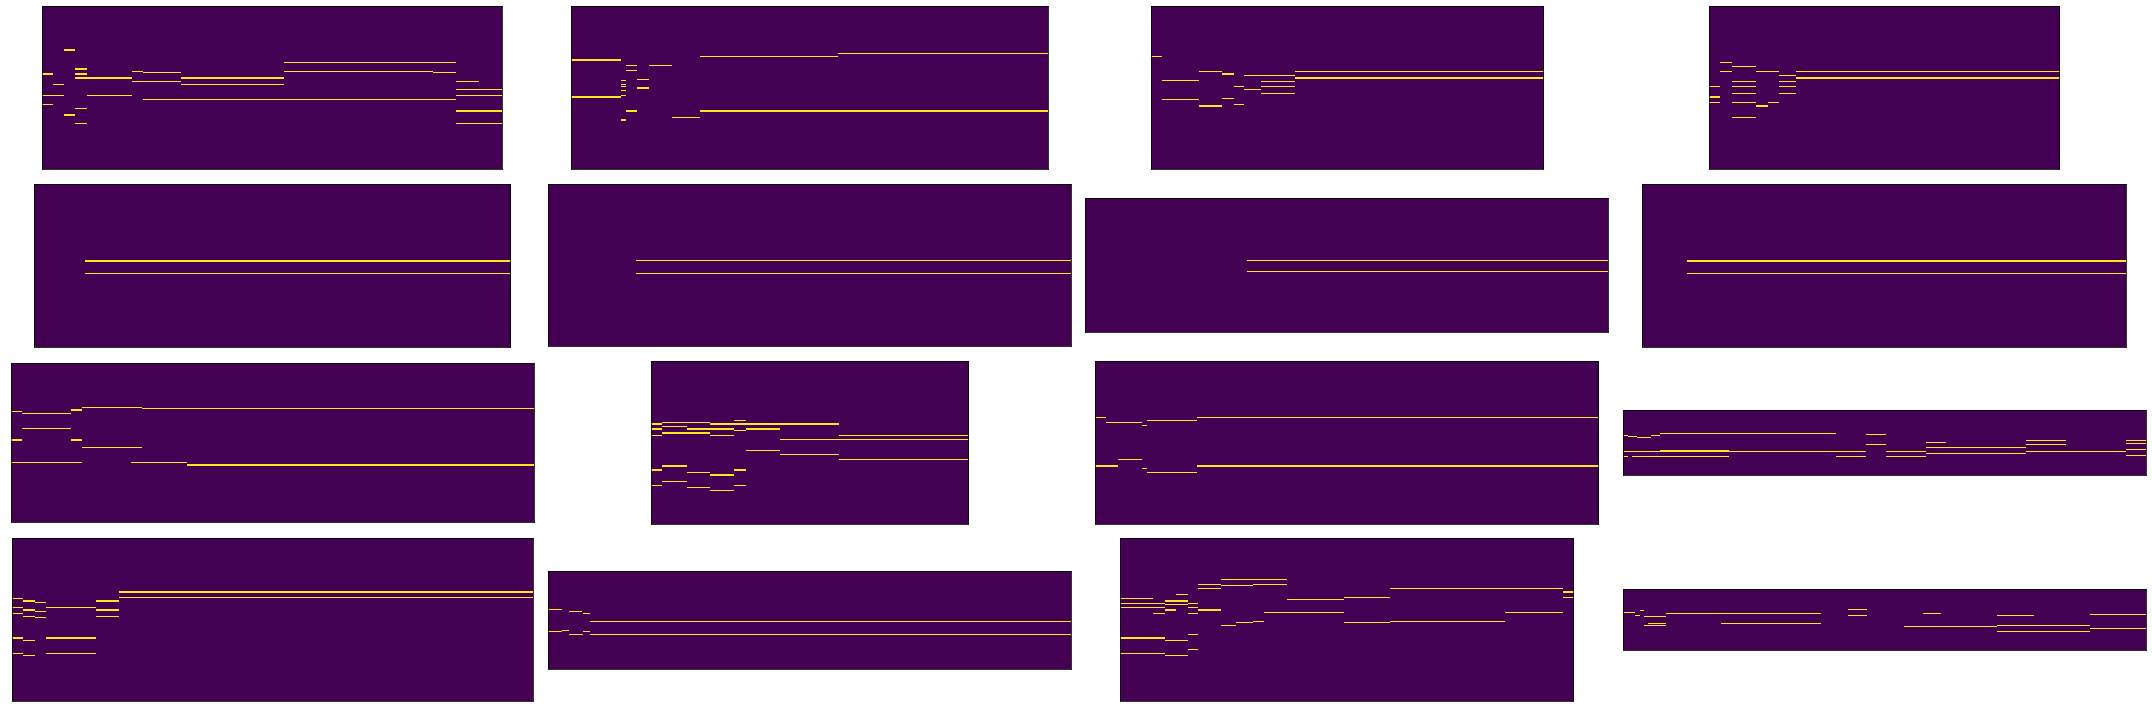

500/500 [==============================] - 19s 38ms/step - loss: 831.6043 - notes_output_loss: 21.5177 - duration_output_loss: 1.2658 - notes_output_mean_squared_error: 21.4564 - duration_output_categorical_accuracy: 0.6115 - val_loss: 1054.4360 - val_notes_output_loss: 23.1810 - val_duration_output_loss: 1.6113 - val_notes_output_mean_squared_error: 23.1087 - val_duration_output_categorical_accuracy: 0.5832
Epoch 2/25
 98/500 [====>.........................] - ETA: 2s - loss: 1146.4339 - notes_output_loss: 21.5545 - duration_output_loss: 1.7576 - notes_output_mean_squared_error: 21.5310 - duration_output_categorical_accuracy: 0.5524

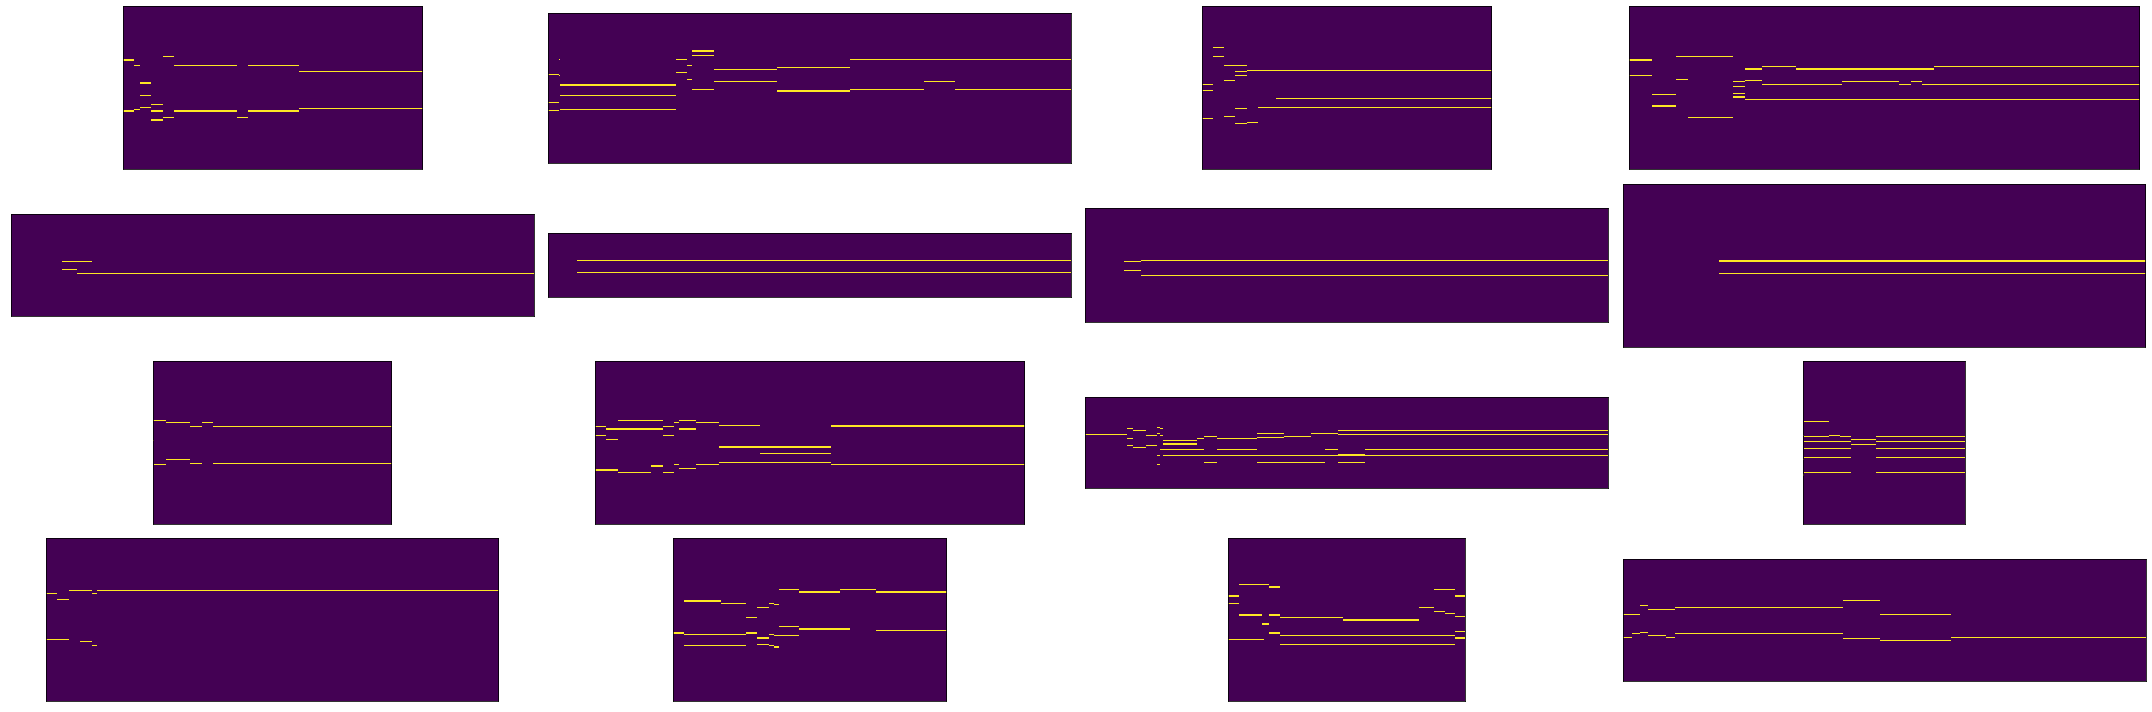

500/500 [==============================] - 15s 29ms/step - loss: 365.4368 - notes_output_loss: 15.6121 - duration_output_loss: 0.5466 - notes_output_mean_squared_error: 15.5613 - duration_output_categorical_accuracy: 0.8113 - val_loss: 1146.1244 - val_notes_output_loss: 21.5957 - val_duration_output_loss: 1.7571 - val_notes_output_mean_squared_error: 21.5810 - val_duration_output_categorical_accuracy: 0.5509
Epoch 3/25
 93/500 [====>.........................] - ETA: 2s - loss: 1362.4507 - notes_output_loss: 20.7291 - duration_output_loss: 2.0964 - notes_output_mean_squared_error: 20.7014 - duration_output_categorical_accuracy: 0.6010

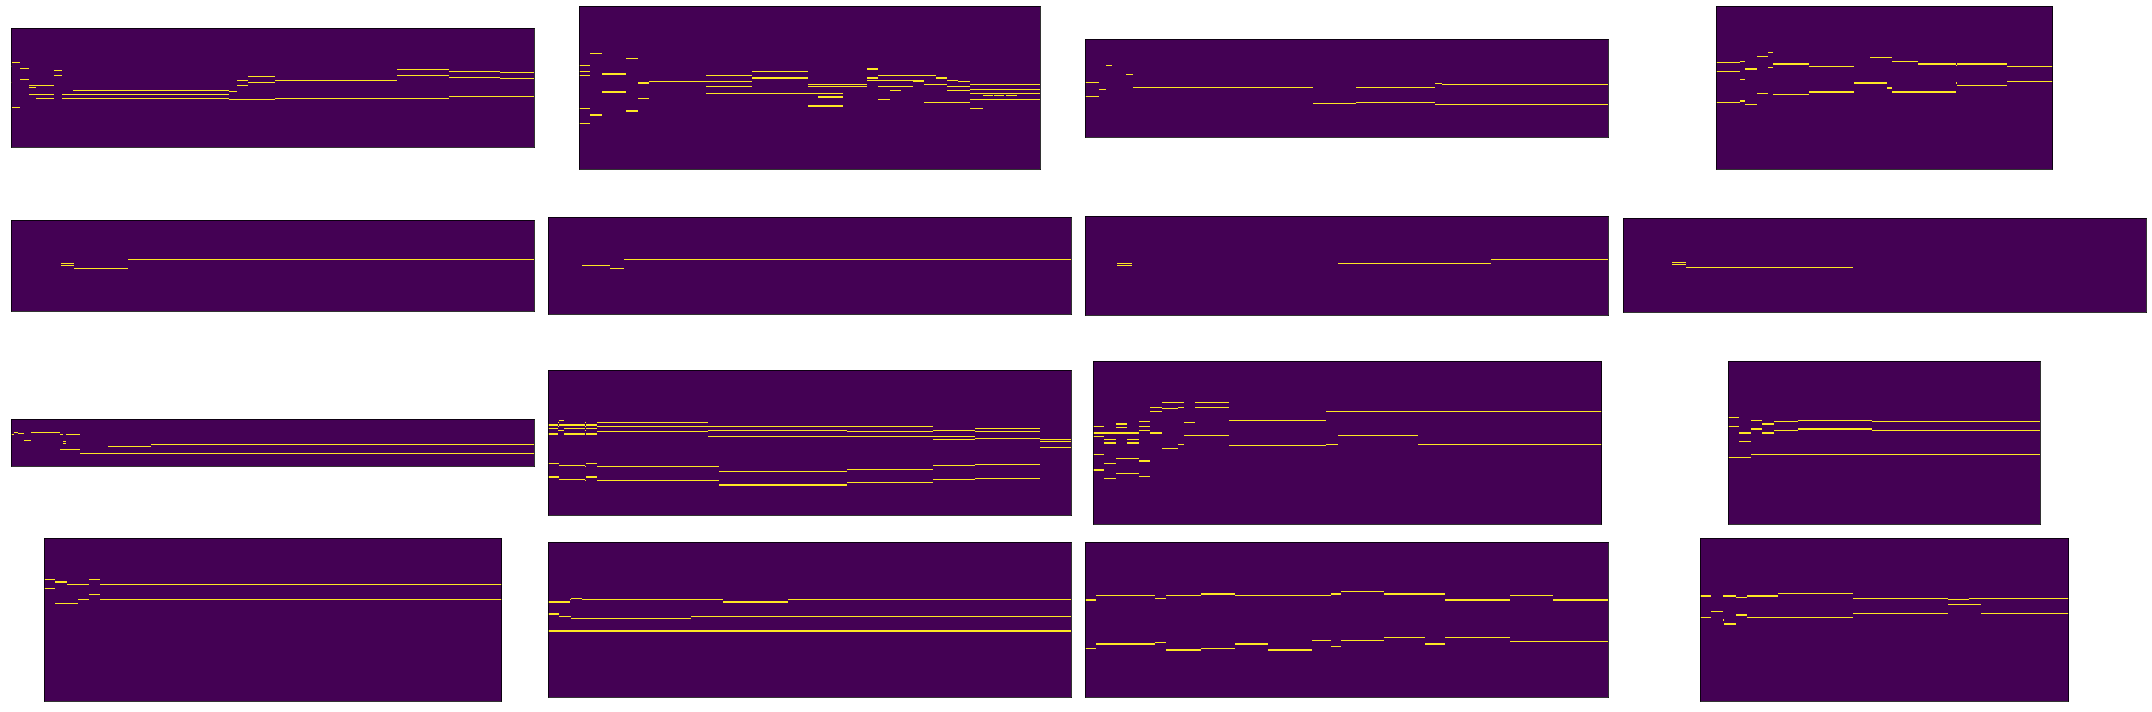

500/500 [==============================] - 14s 28ms/step - loss: 194.6089 - notes_output_loss: 13.8132 - duration_output_loss: 0.2825 - notes_output_mean_squared_error: 13.6914 - duration_output_categorical_accuracy: 0.9091 - val_loss: 1341.2386 - val_notes_output_loss: 20.6514 - val_duration_output_loss: 2.0634 - val_notes_output_mean_squared_error: 20.6024 - val_duration_output_categorical_accuracy: 0.6052
Epoch 4/25
 90/500 [====>.........................] - ETA: 2s - loss: 1347.1425 - notes_output_loss: 18.8744 - duration_output_loss: 2.0754 - notes_output_mean_squared_error: 18.8911 - duration_output_categorical_accuracy: 0.6331

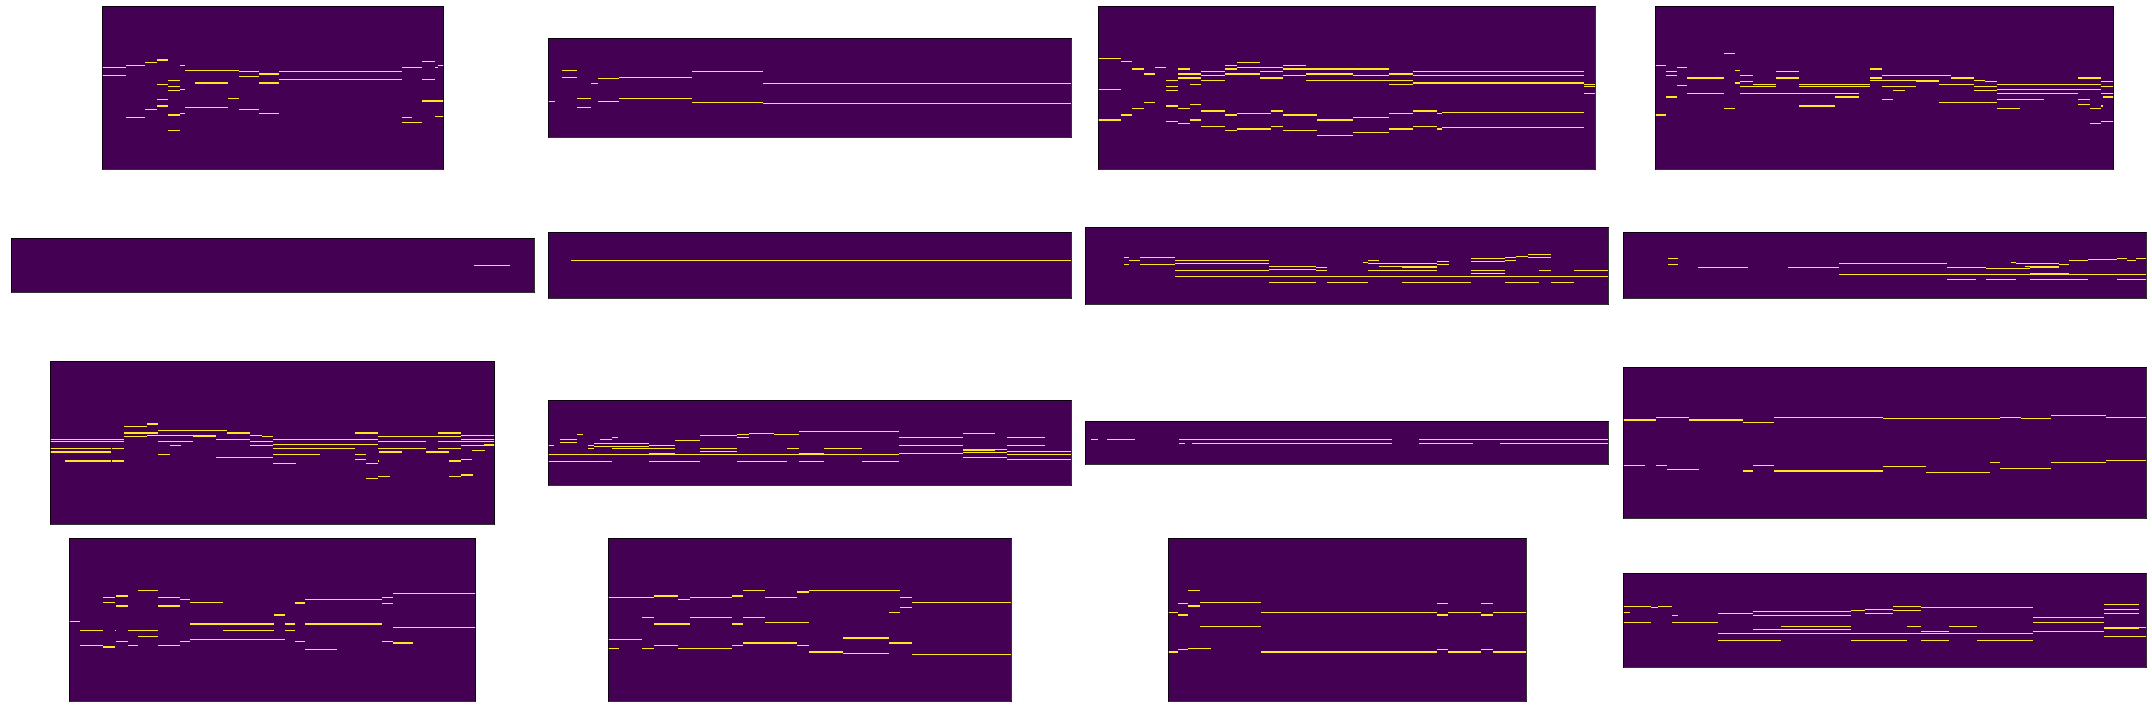

500/500 [==============================] - 13s 27ms/step - loss: 120.3120 - notes_output_loss: 12.3590 - duration_output_loss: 0.1687 - notes_output_mean_squared_error: 12.3465 - duration_output_categorical_accuracy: 0.9469 - val_loss: 1364.9321 - val_notes_output_loss: 19.0663 - val_duration_output_loss: 2.1029 - val_notes_output_mean_squared_error: 19.0851 - val_duration_output_categorical_accuracy: 0.6253
Epoch 5/25
 97/500 [====>.........................] - ETA: 2s - loss: 1580.3375 - notes_output_loss: 19.1839 - duration_output_loss: 2.4393 - notes_output_mean_squared_error: 19.0735 - duration_output_categorical_accuracy: 0.6279

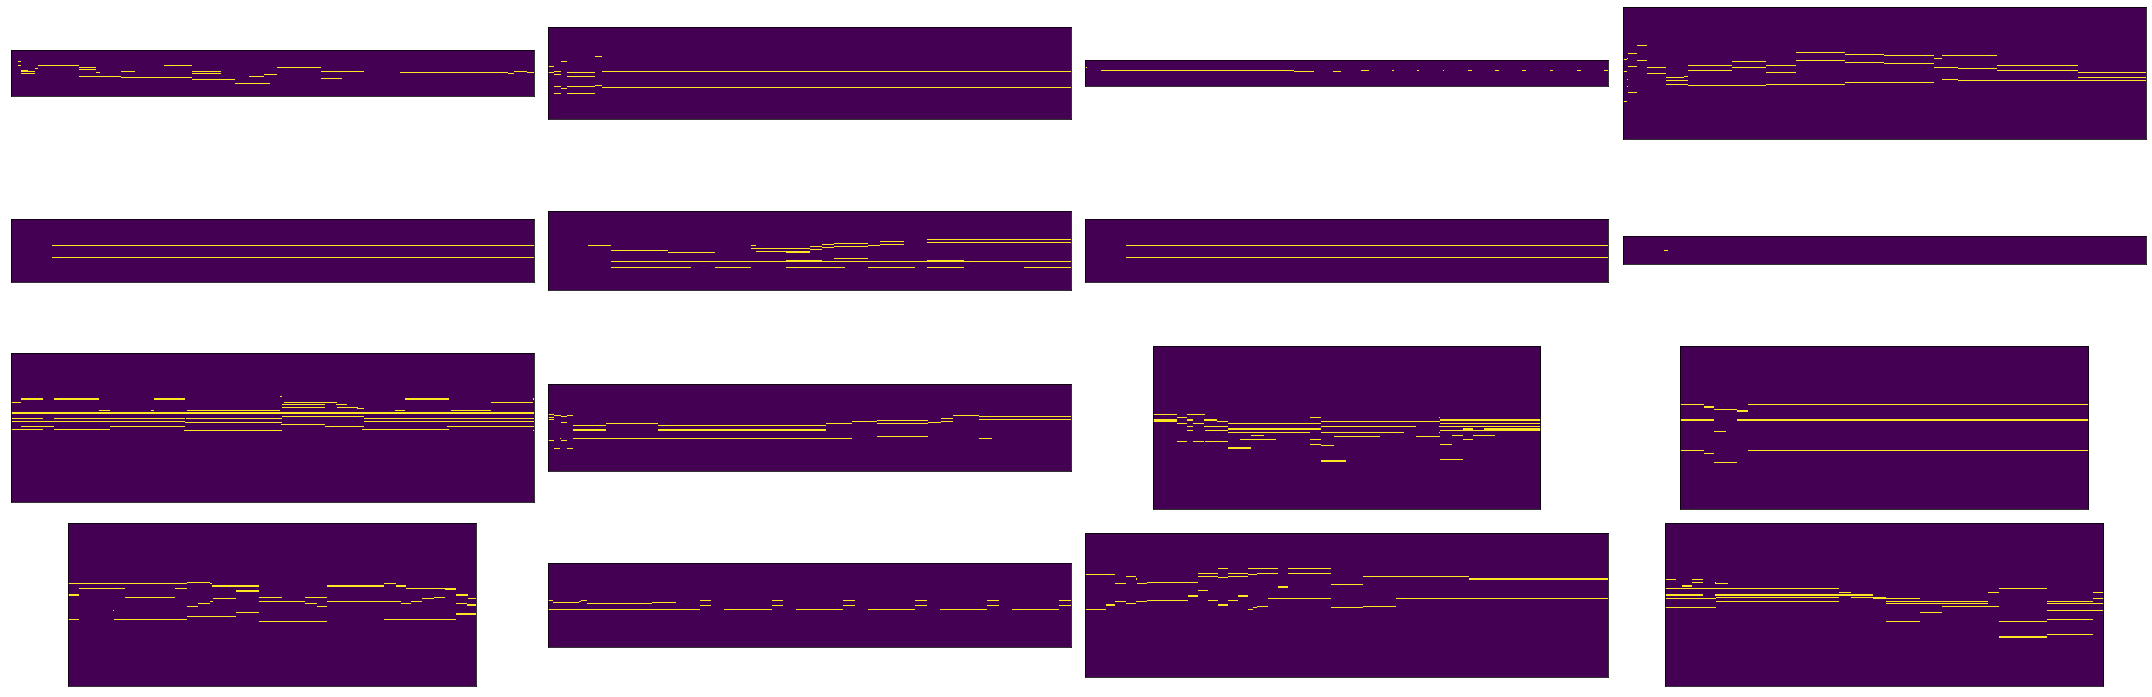

500/500 [==============================] - 14s 29ms/step - loss: 84.5686 - notes_output_loss: 11.3202 - duration_output_loss: 0.1145 - notes_output_mean_squared_error: 11.3030 - duration_output_categorical_accuracy: 0.9656 - val_loss: 1577.9486 - val_notes_output_loss: 19.2059 - val_duration_output_loss: 2.4355 - val_notes_output_mean_squared_error: 19.0679 - val_duration_output_categorical_accuracy: 0.6285
Epoch 6/25
 98/500 [====>.........................] - ETA: 2s - loss: 1616.1254 - notes_output_loss: 20.1975 - duration_output_loss: 2.4936 - notes_output_mean_squared_error: 20.1388 - duration_output_categorical_accuracy: 0.6252

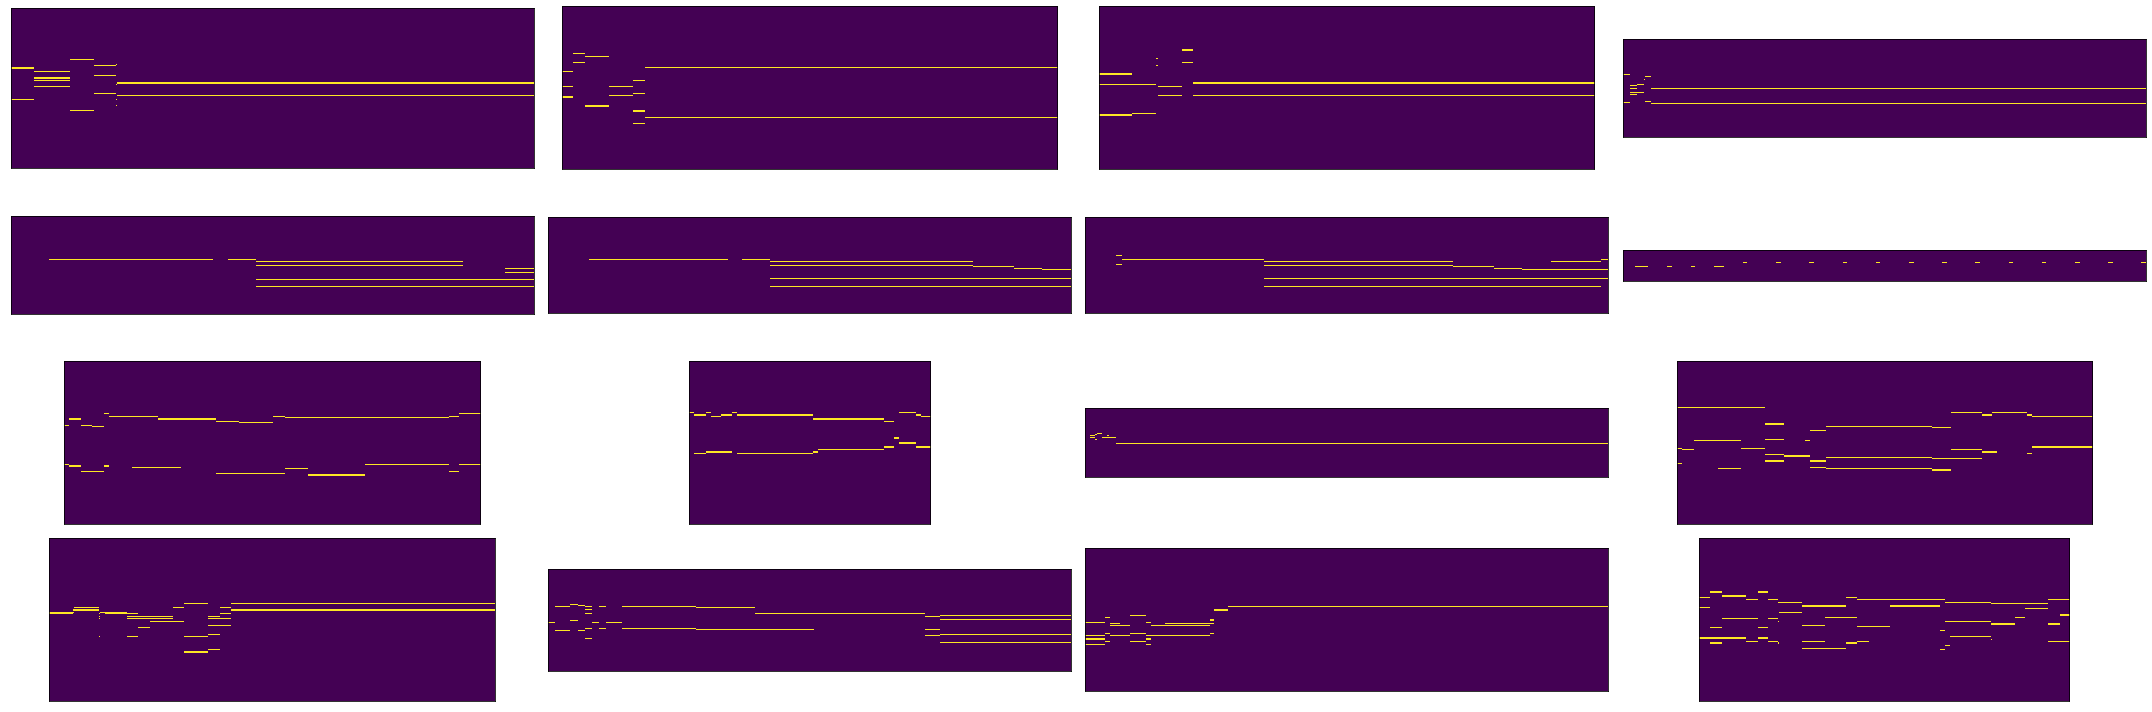

500/500 [==============================] - 14s 27ms/step - loss: 63.2636 - notes_output_loss: 10.8434 - duration_output_loss: 0.0819 - notes_output_mean_squared_error: 10.7797 - duration_output_categorical_accuracy: 0.9773 - val_loss: 1623.1538 - val_notes_output_loss: 20.2428 - val_duration_output_loss: 2.5045 - val_notes_output_mean_squared_error: 20.2036 - val_duration_output_categorical_accuracy: 0.6221
Epoch 7/25
 90/500 [====>.........................] - ETA: 2s - loss: 1701.9664 - notes_output_loss: 19.4019 - duration_output_loss: 2.6290 - notes_output_mean_squared_error: 19.4092 - duration_output_categorical_accuracy: 0.6272

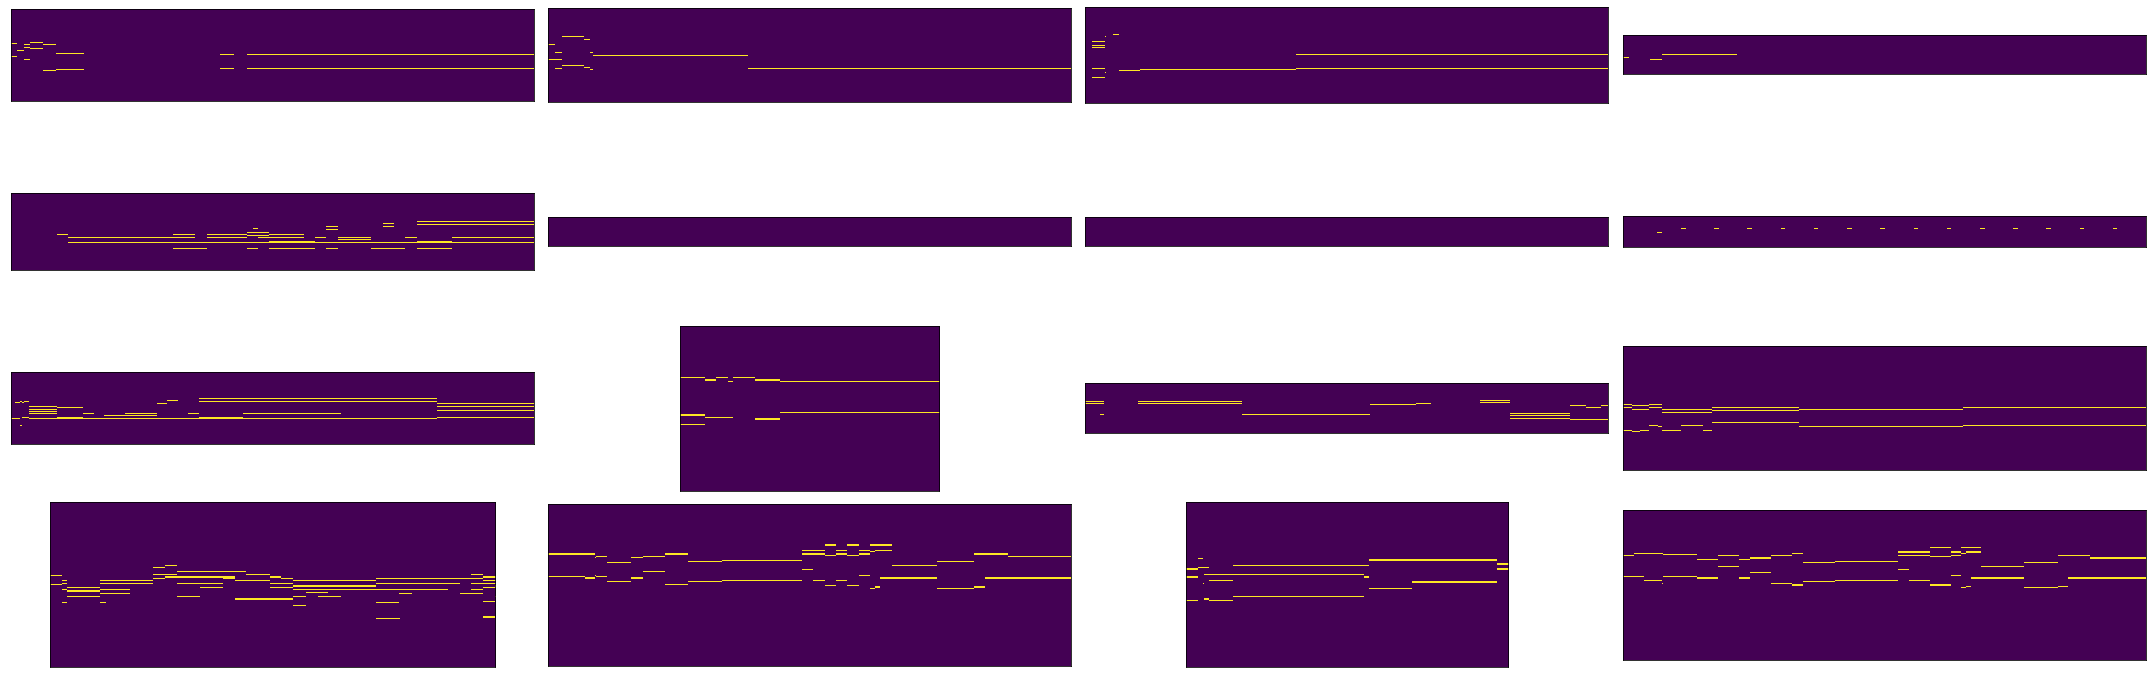

500/500 [==============================] - 14s 28ms/step - loss: 54.3002 - notes_output_loss: 10.1111 - duration_output_loss: 0.0690 - notes_output_mean_squared_error: 9.9792 - duration_output_categorical_accuracy: 0.9802 - val_loss: 1683.5464 - val_notes_output_loss: 19.4262 - val_duration_output_loss: 2.6002 - val_notes_output_mean_squared_error: 19.4467 - val_duration_output_categorical_accuracy: 0.6274
Epoch 8/25
 93/500 [====>.........................] - ETA: 2s - loss: 1824.8893 - notes_output_loss: 19.9211 - duration_output_loss: 2.8203 - notes_output_mean_squared_error: 19.6841 - duration_output_categorical_accuracy: 0.6107

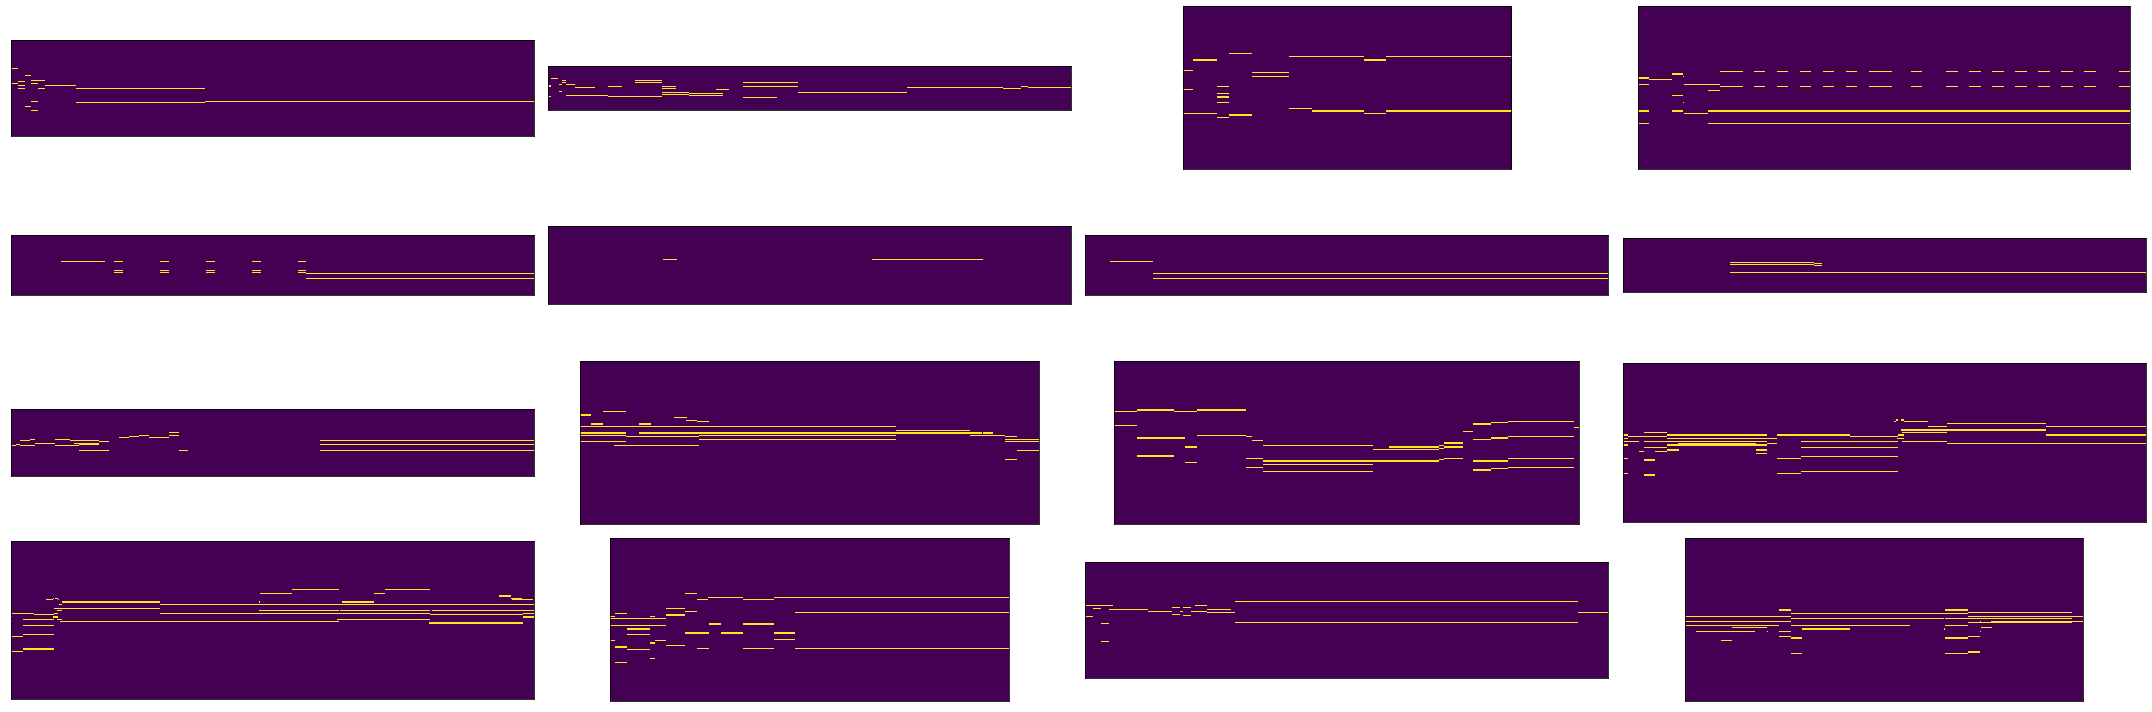

500/500 [==============================] - 14s 28ms/step - loss: 45.7154 - notes_output_loss: 9.2300 - duration_output_loss: 0.0570 - notes_output_mean_squared_error: 9.1305 - duration_output_categorical_accuracy: 0.9842 - val_loss: 1834.3164 - val_notes_output_loss: 20.0090 - val_duration_output_loss: 2.8349 - val_notes_output_mean_squared_error: 19.8015 - val_duration_output_categorical_accuracy: 0.6065
Epoch 9/25
 91/500 [====>.........................] - ETA: 2s - loss: 1606.3570 - notes_output_loss: 19.7250 - duration_output_loss: 2.4791 - notes_output_mean_squared_error: 19.5934 - duration_output_categorical_accuracy: 0.6356

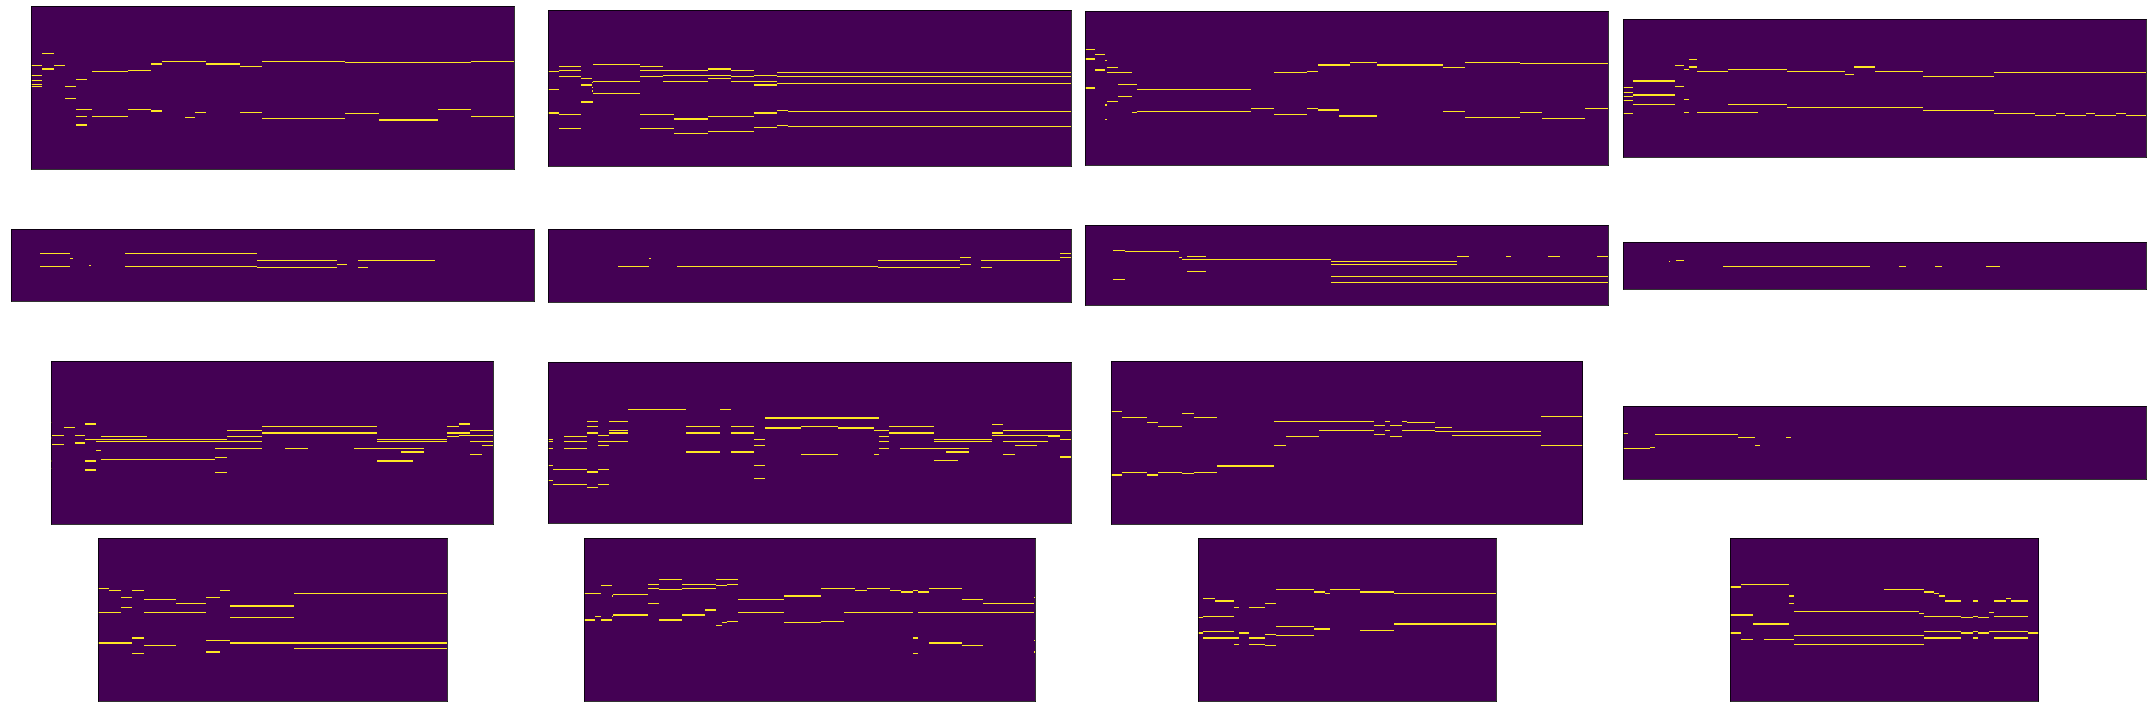

500/500 [==============================] - 15s 29ms/step - loss: 44.0642 - notes_output_loss: 8.7660 - duration_output_loss: 0.0552 - notes_output_mean_squared_error: 8.7028 - duration_output_categorical_accuracy: 0.9849 - val_loss: 1591.1397 - val_notes_output_loss: 19.6870 - val_duration_output_loss: 2.4554 - val_notes_output_mean_squared_error: 19.5516 - val_duration_output_categorical_accuracy: 0.6386
Epoch 10/25
 97/500 [====>.........................] - ETA: 2s - loss: 1902.2180 - notes_output_loss: 20.7091 - duration_output_loss: 2.9399 - notes_output_mean_squared_error: 20.6928 - duration_output_categorical_accuracy: 0.5965

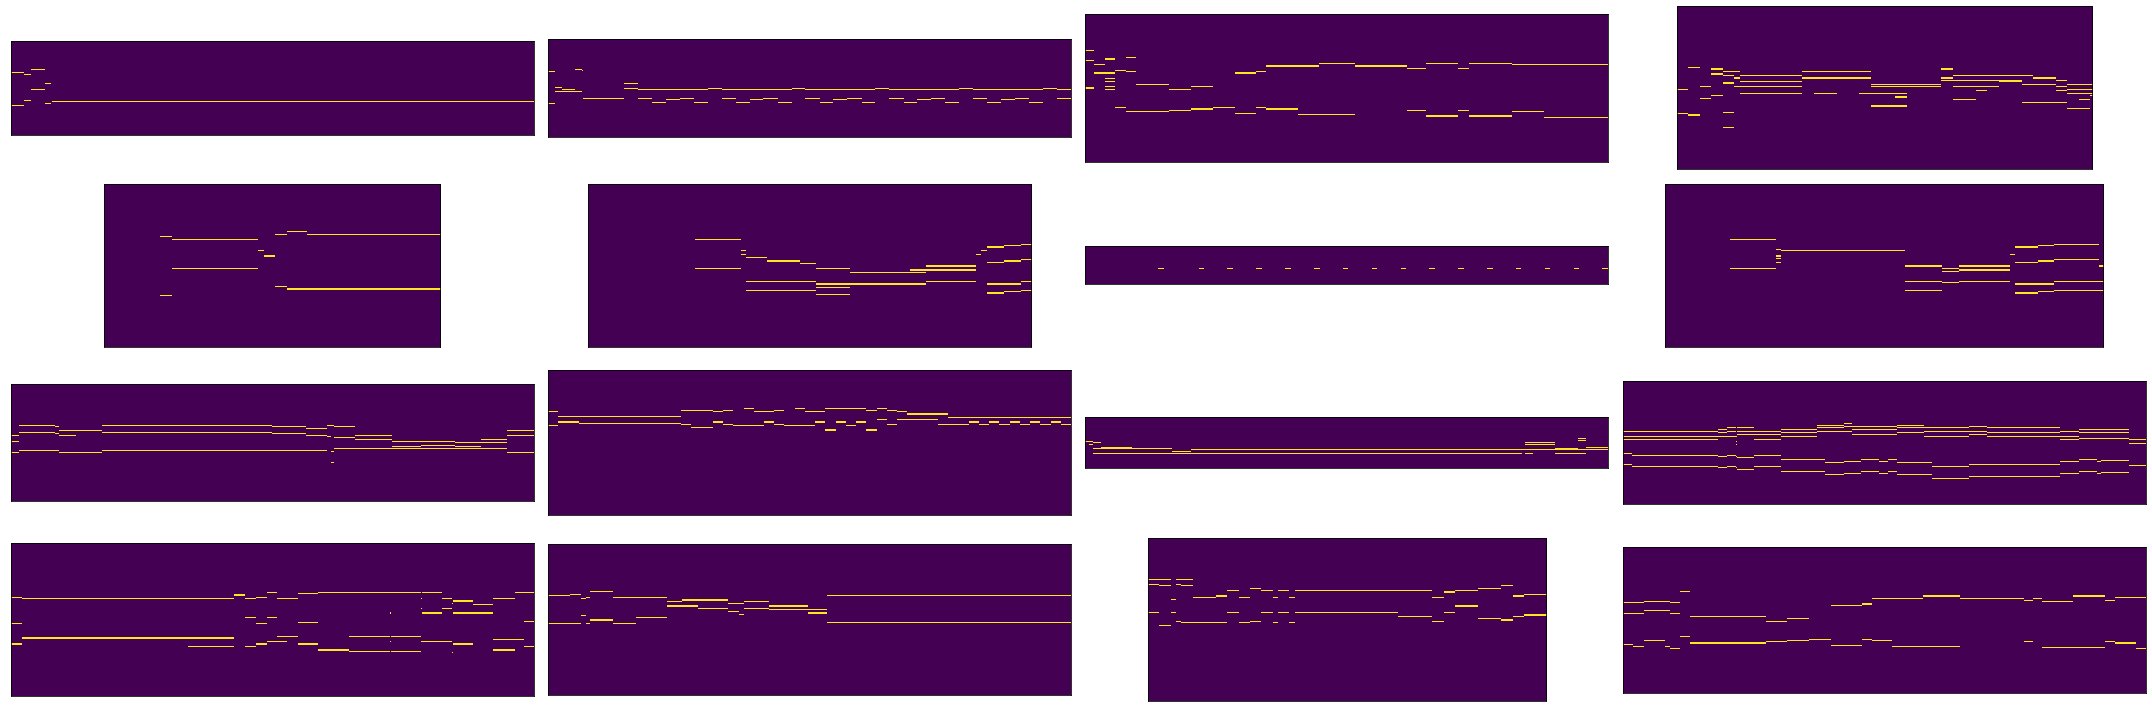

500/500 [==============================] - 14s 28ms/step - loss: 41.3164 - notes_output_loss: 8.5133 - duration_output_loss: 0.0513 - notes_output_mean_squared_error: 8.4403 - duration_output_categorical_accuracy: 0.9853 - val_loss: 1907.1041 - val_notes_output_loss: 20.7696 - val_duration_output_loss: 2.9474 - val_notes_output_mean_squared_error: 20.7492 - val_duration_output_categorical_accuracy: 0.5949
Epoch 11/25
 92/500 [====>.........................] - ETA: 2s - loss: 1534.1384 - notes_output_loss: 18.7262 - duration_output_loss: 2.3678 - notes_output_mean_squared_error: 18.6623 - duration_output_categorical_accuracy: 0.6899

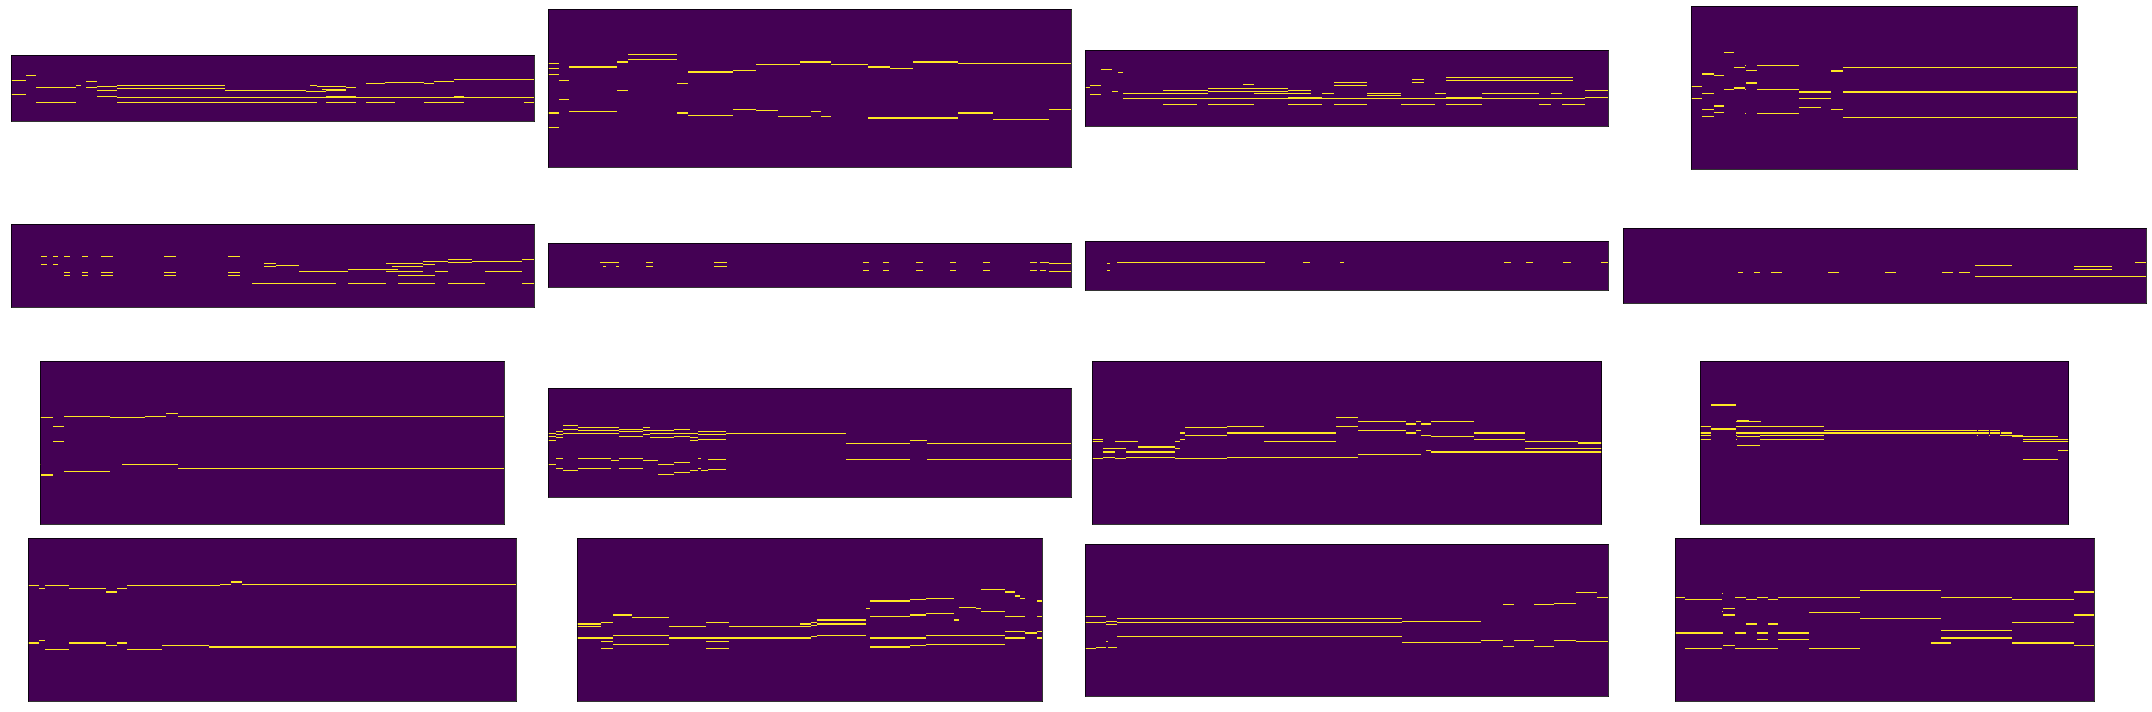

500/500 [==============================] - 16s 32ms/step - loss: 31.8332 - notes_output_loss: 7.7984 - duration_output_loss: 0.0376 - notes_output_mean_squared_error: 7.7045 - duration_output_categorical_accuracy: 0.9887 - val_loss: 1515.6746 - val_notes_output_loss: 18.6650 - val_duration_output_loss: 2.3391 - val_notes_output_mean_squared_error: 18.5908 - val_duration_output_categorical_accuracy: 0.6923
Epoch 12/25
100/500 [=====>........................] - ETA: 2s - loss: 1712.9954 - notes_output_loss: 18.4620 - duration_output_loss: 2.6477 - notes_output_mean_squared_error: 18.3823 - duration_output_categorical_accuracy: 0.6513

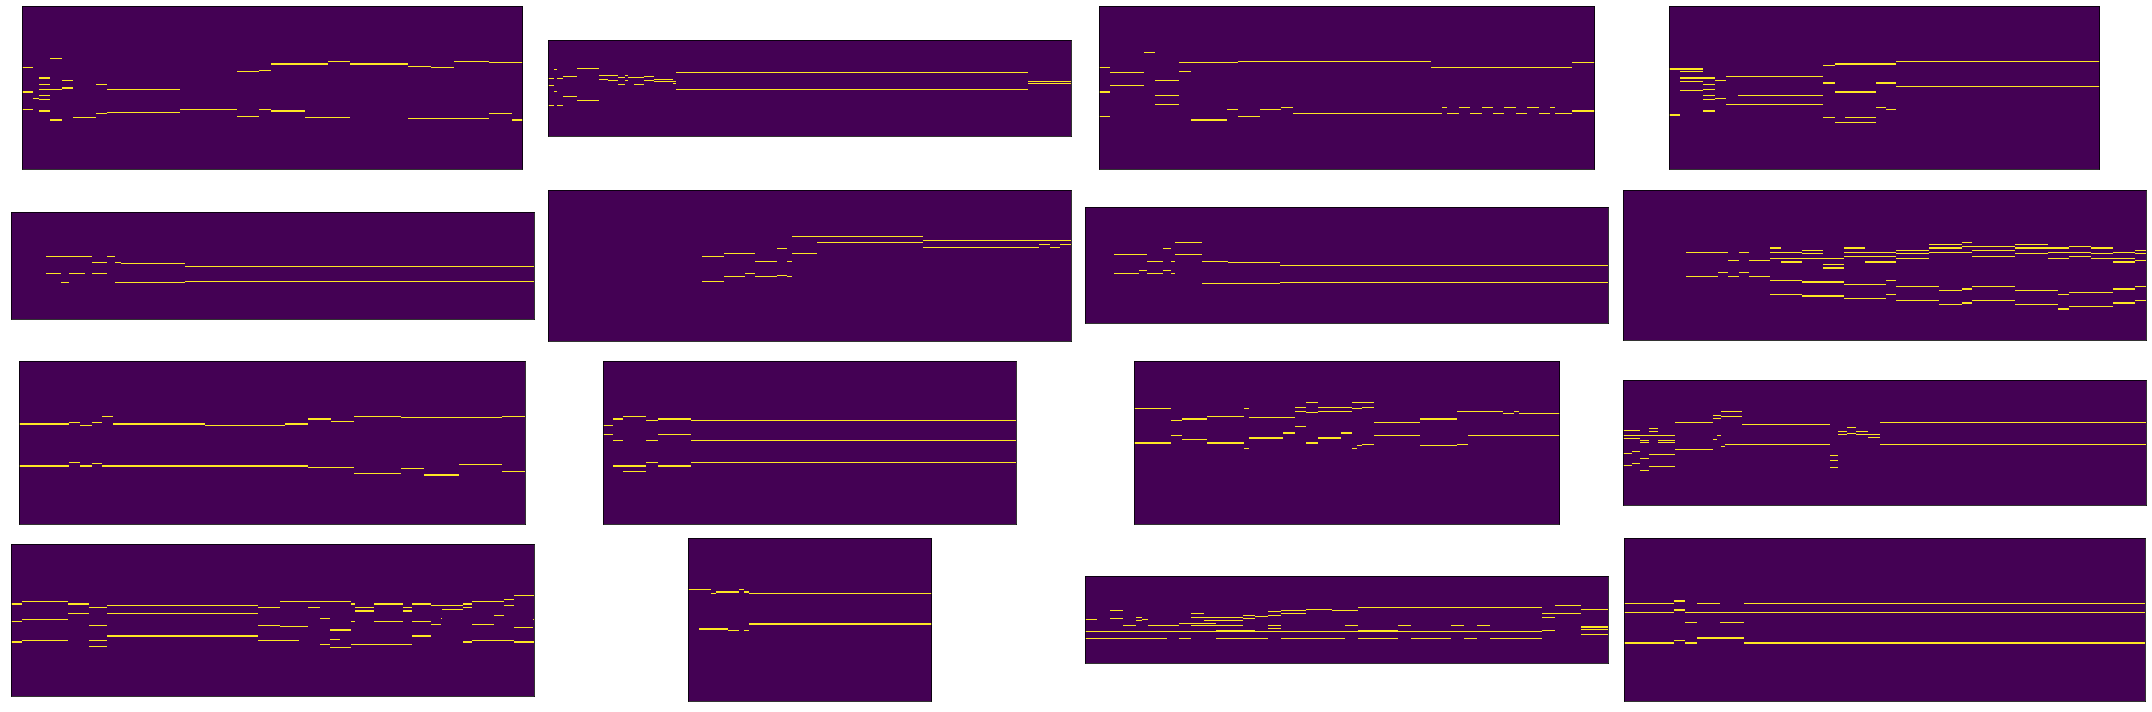

500/500 [==============================] - 14s 29ms/step - loss: 34.2332 - notes_output_loss: 7.6628 - duration_output_loss: 0.0415 - notes_output_mean_squared_error: 7.5339 - duration_output_categorical_accuracy: 0.9877 - val_loss: 1712.9954 - val_notes_output_loss: 18.4620 - val_duration_output_loss: 2.6477 - val_notes_output_mean_squared_error: 18.3823 - val_duration_output_categorical_accuracy: 0.6513
Epoch 13/25
 98/500 [====>.........................] - ETA: 2s - loss: 1940.7629 - notes_output_loss: 19.4022 - duration_output_loss: 3.0021 - notes_output_mean_squared_error: 19.3615 - duration_output_categorical_accuracy: 0.6008

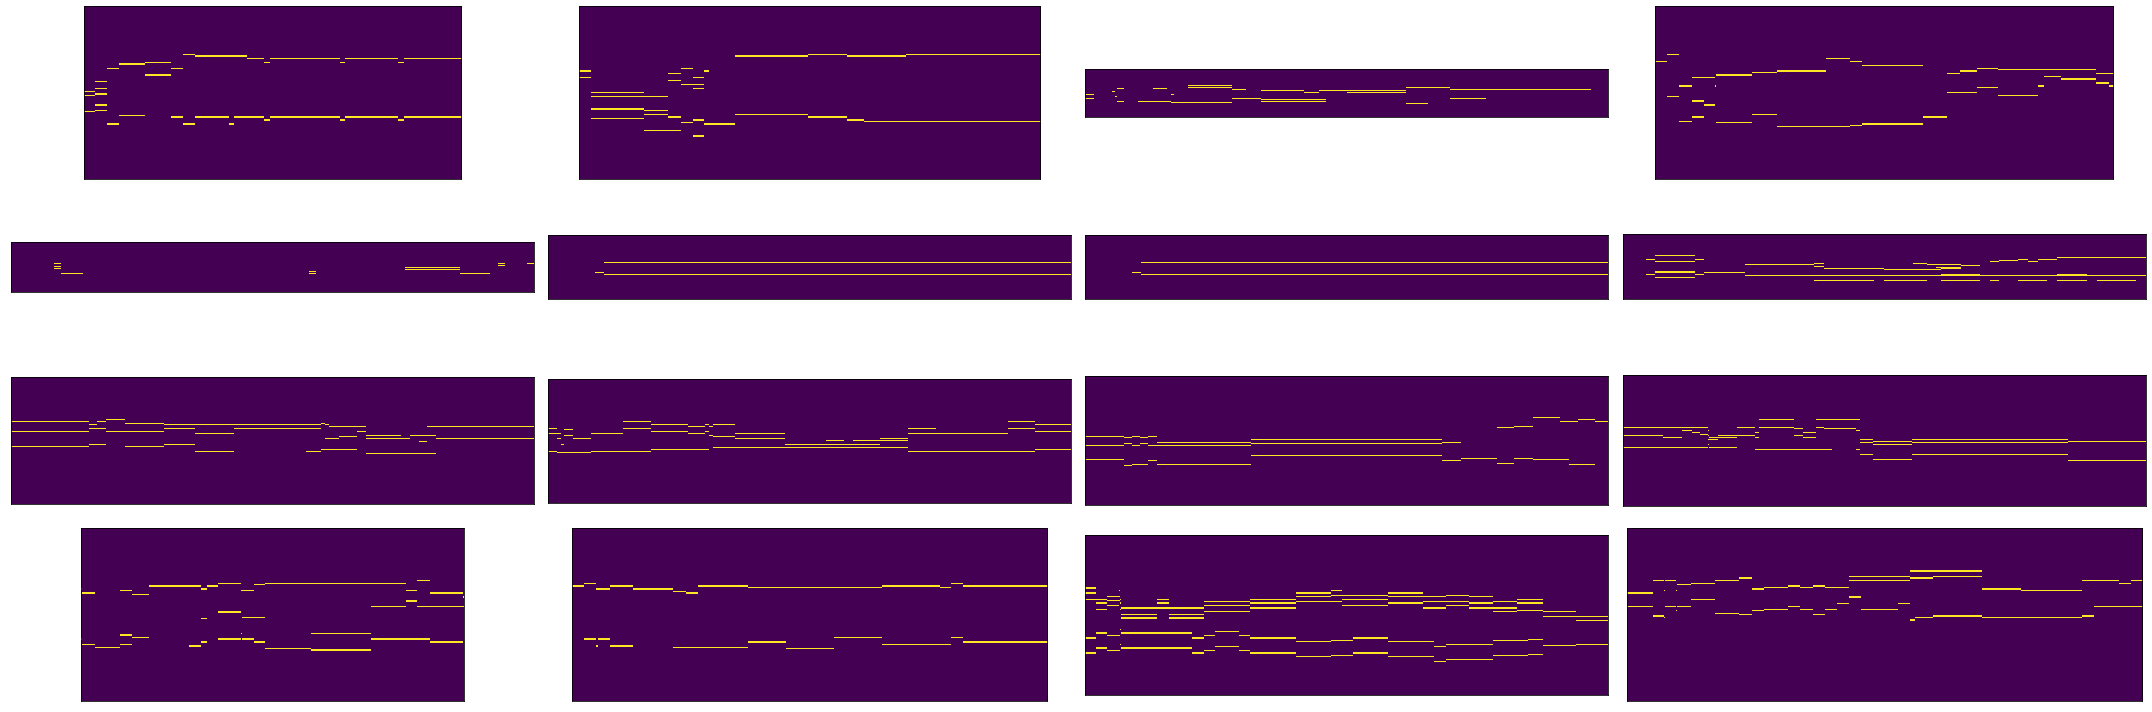

500/500 [==============================] - 14s 27ms/step - loss: 38.7085 - notes_output_loss: 7.4326 - duration_output_loss: 0.0489 - notes_output_mean_squared_error: 7.3386 - duration_output_categorical_accuracy: 0.9856 - val_loss: 1956.2885 - val_notes_output_loss: 19.4522 - val_duration_output_loss: 3.0263 - val_notes_output_mean_squared_error: 19.4295 - val_duration_output_categorical_accuracy: 0.5974
Epoch 14/25
 92/500 [====>.........................] - ETA: 2s - loss: 1639.2909 - notes_output_loss: 17.9290 - duration_output_loss: 2.5334 - notes_output_mean_squared_error: 17.9312 - duration_output_categorical_accuracy: 0.6566

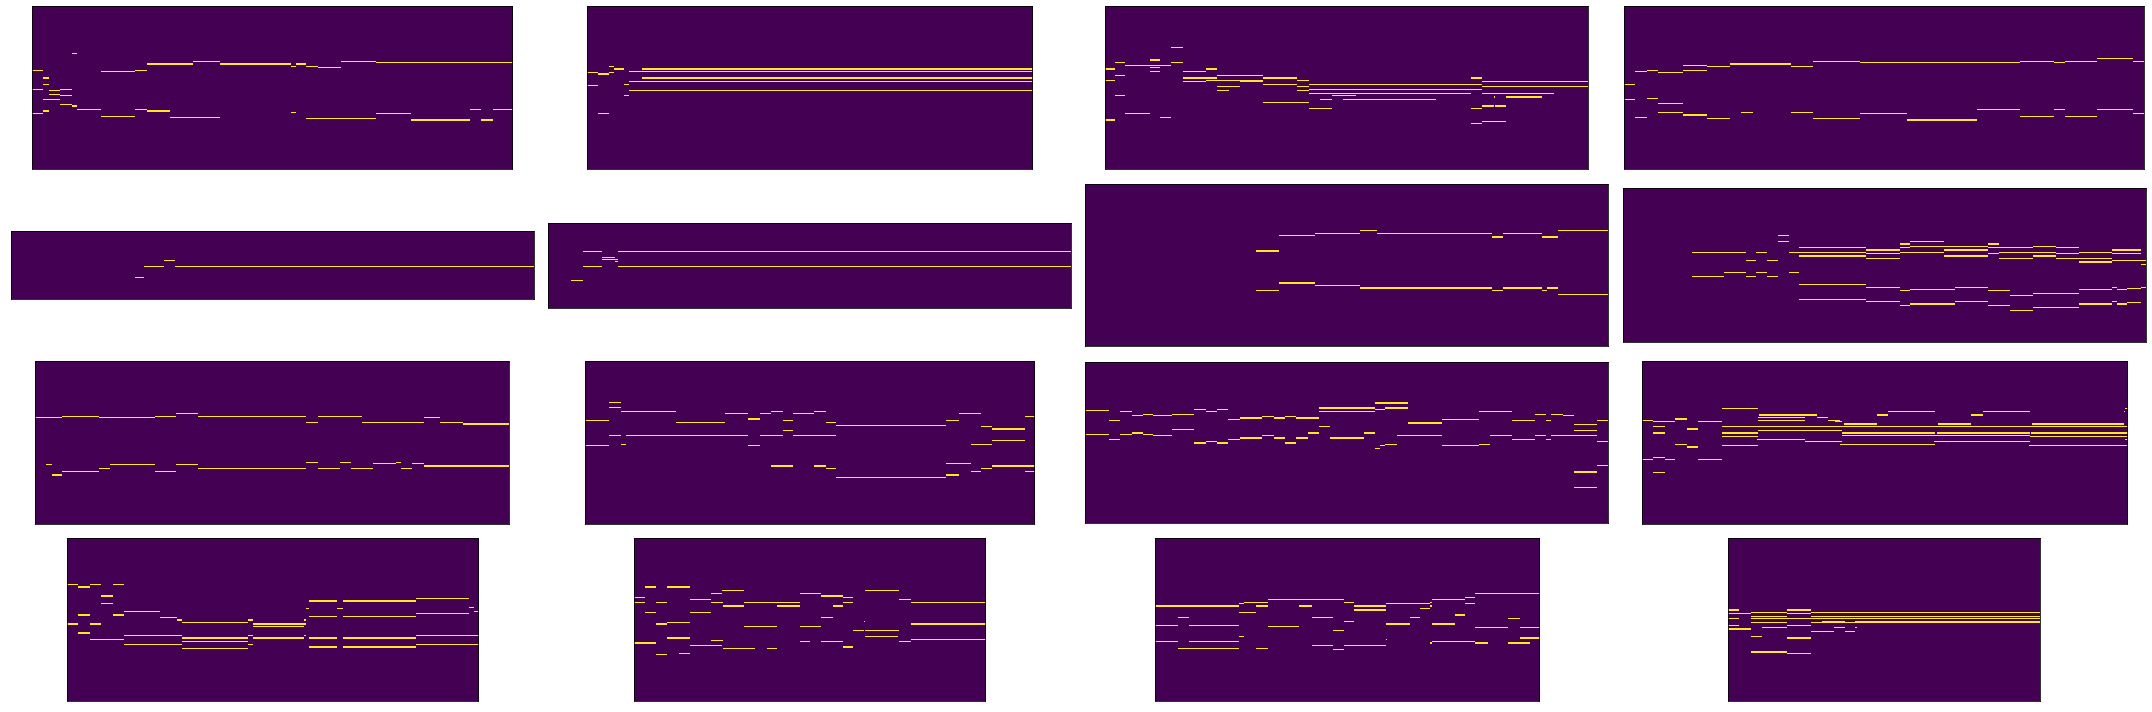

500/500 [==============================] - 13s 26ms/step - loss: 31.9596 - notes_output_loss: 6.7386 - duration_output_loss: 0.0394 - notes_output_mean_squared_error: 6.6347 - duration_output_categorical_accuracy: 0.9878 - val_loss: 1679.4671 - val_notes_output_loss: 18.1340 - val_duration_output_loss: 2.5958 - val_notes_output_mean_squared_error: 18.1287 - val_duration_output_categorical_accuracy: 0.6488
Epoch 15/25
 94/500 [====>.........................] - ETA: 2s - loss: 1792.7280 - notes_output_loss: 18.9383 - duration_output_loss: 2.7715 - notes_output_mean_squared_error: 18.7543 - duration_output_categorical_accuracy: 0.6528

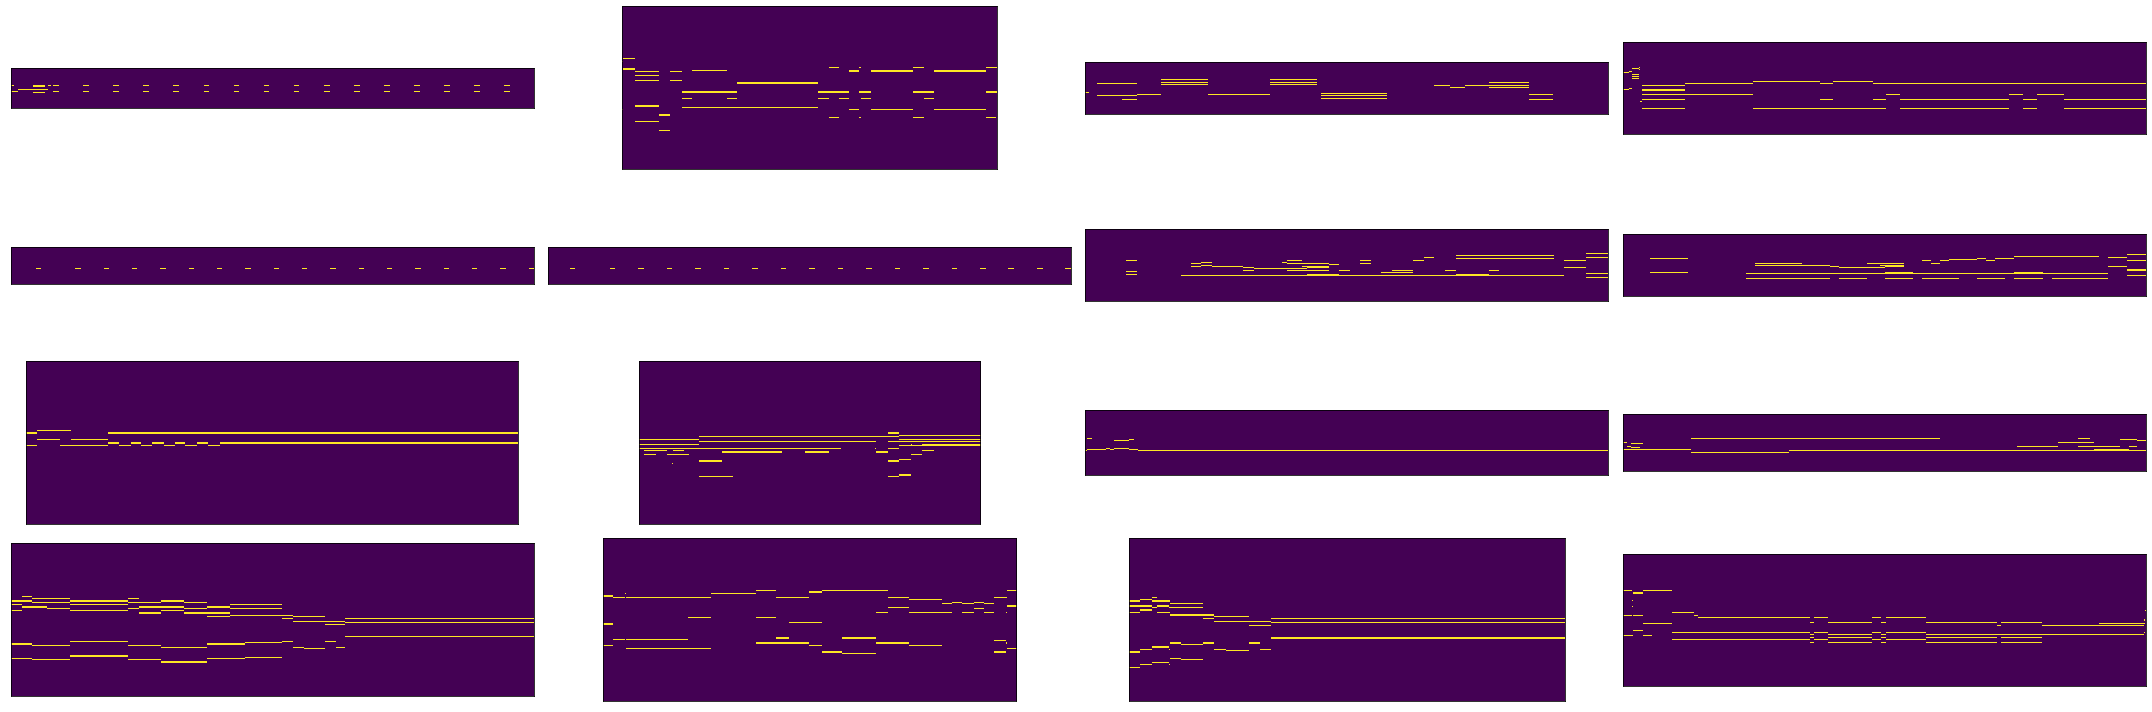

500/500 [==============================] - 13s 26ms/step - loss: 28.4303 - notes_output_loss: 6.7726 - duration_output_loss: 0.0338 - notes_output_mean_squared_error: 6.6853 - duration_output_categorical_accuracy: 0.9897 - val_loss: 1762.3903 - val_notes_output_loss: 18.9203 - val_duration_output_loss: 2.7242 - val_notes_output_mean_squared_error: 18.7527 - val_duration_output_categorical_accuracy: 0.6569
Epoch 16/25
100/500 [=====>........................] - ETA: 2s - loss: 1600.6462 - notes_output_loss: 18.6307 - duration_output_loss: 2.4719 - notes_output_mean_squared_error: 18.6910 - duration_output_categorical_accuracy: 0.6561

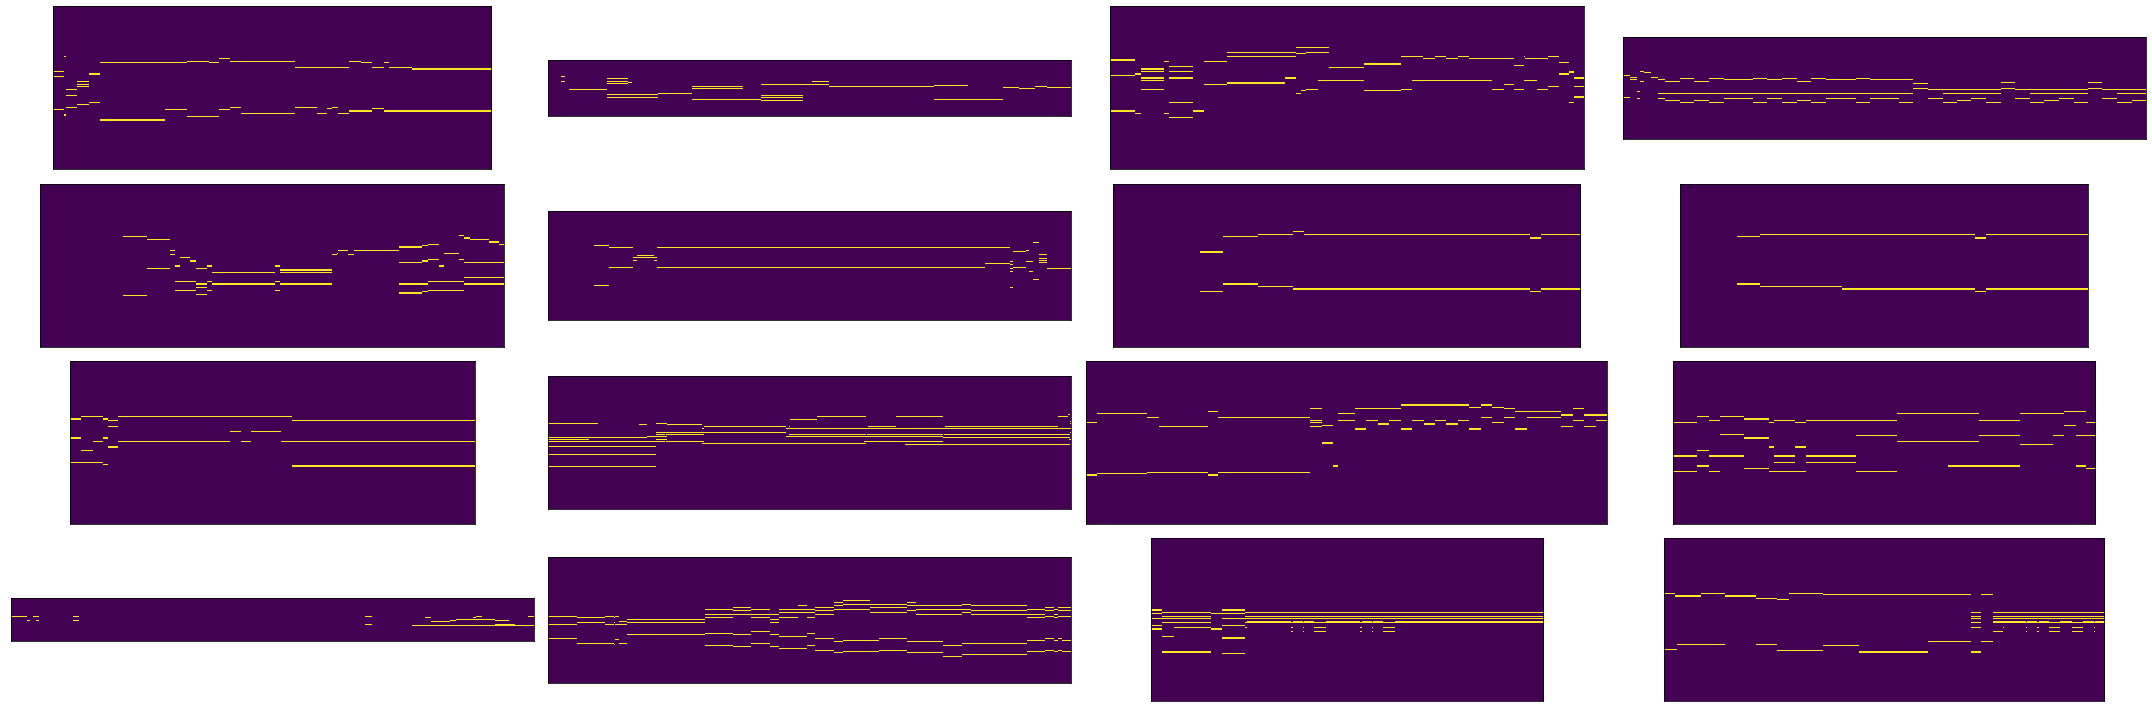

500/500 [==============================] - 13s 26ms/step - loss: 26.6854 - notes_output_loss: 6.6259 - duration_output_loss: 0.0313 - notes_output_mean_squared_error: 6.4525 - duration_output_categorical_accuracy: 0.9897 - val_loss: 1600.6462 - val_notes_output_loss: 18.6307 - val_duration_output_loss: 2.4719 - val_notes_output_mean_squared_error: 18.6910 - val_duration_output_categorical_accuracy: 0.6561
Epoch 17/25
 92/500 [====>.........................] - ETA: 2s - loss: 1699.8492 - notes_output_loss: 19.0516 - duration_output_loss: 2.6262 - notes_output_mean_squared_error: 19.0884 - duration_output_categorical_accuracy: 0.6710

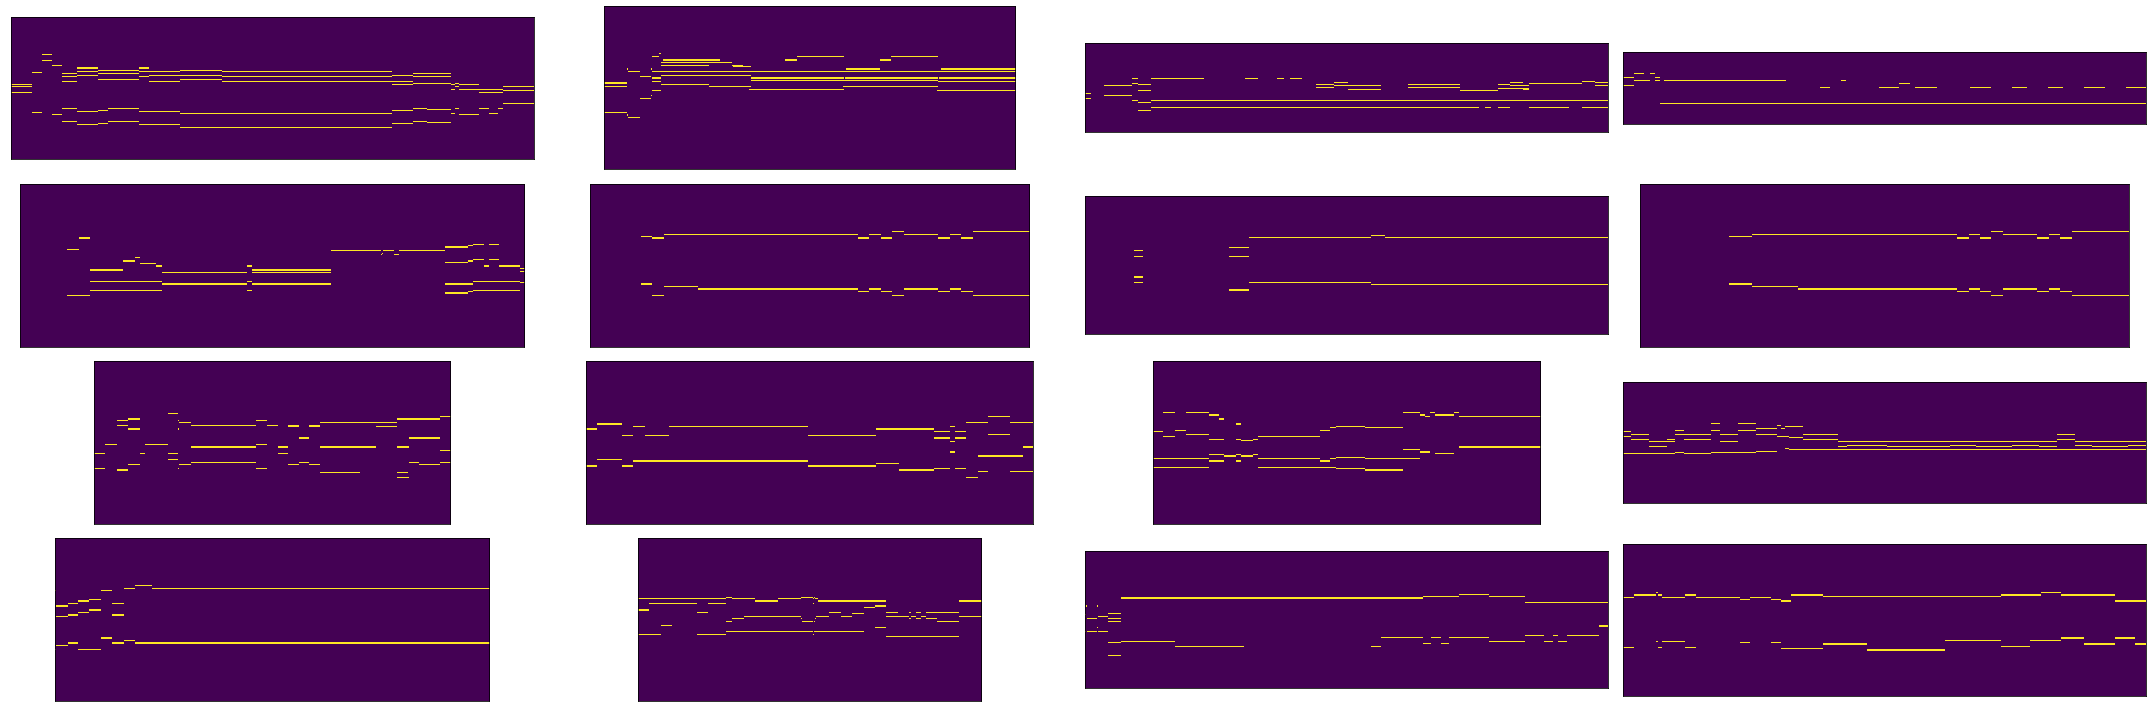

500/500 [==============================] - 14s 28ms/step - loss: 28.4673 - notes_output_loss: 6.3867 - duration_output_loss: 0.0345 - notes_output_mean_squared_error: 6.2915 - duration_output_categorical_accuracy: 0.9893 - val_loss: 1753.9988 - val_notes_output_loss: 19.4770 - val_duration_output_loss: 2.7102 - val_notes_output_mean_squared_error: 19.5244 - val_duration_output_categorical_accuracy: 0.6602
Epoch 18/25
 98/500 [====>.........................] - ETA: 2s - loss: 1582.5309 - notes_output_loss: 18.9634 - duration_output_loss: 2.4431 - notes_output_mean_squared_error: 18.9024 - duration_output_categorical_accuracy: 0.6843

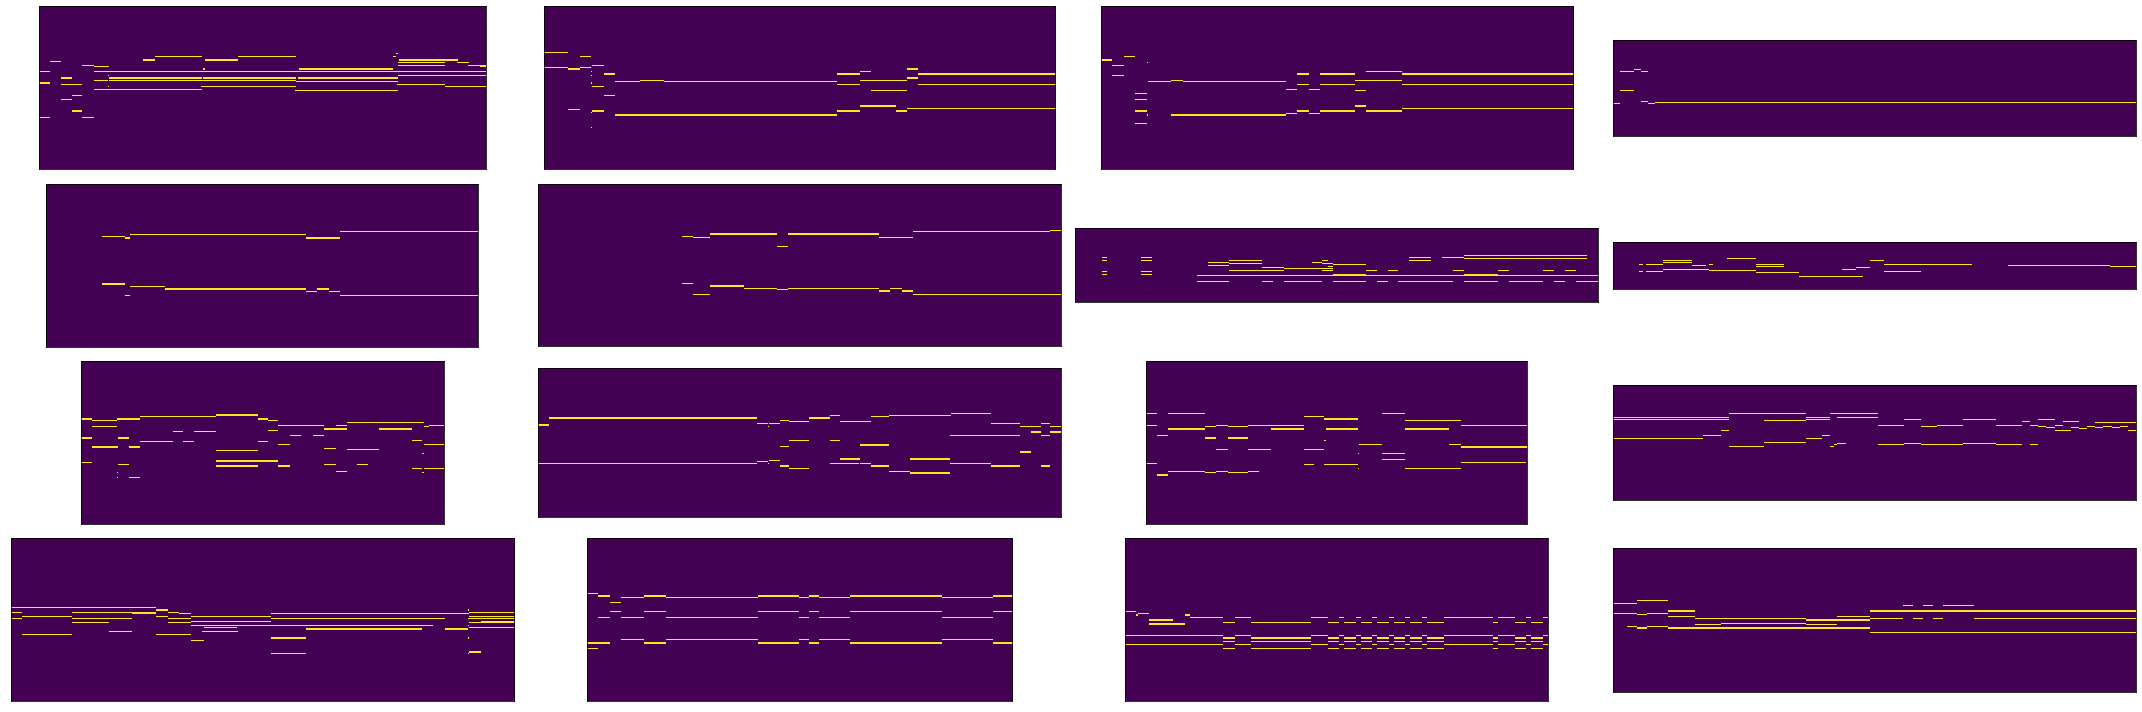

500/500 [==============================] - 14s 28ms/step - loss: 26.6627 - notes_output_loss: 5.9980 - duration_output_loss: 0.0323 - notes_output_mean_squared_error: 5.9596 - duration_output_categorical_accuracy: 0.9898 - val_loss: 1556.5209 - val_notes_output_loss: 18.8120 - val_duration_output_loss: 2.4027 - val_notes_output_mean_squared_error: 18.7338 - val_duration_output_categorical_accuracy: 0.6898
Epoch 19/25
 90/500 [====>.........................] - ETA: 2s - loss: 1608.9739 - notes_output_loss: 19.7016 - duration_output_loss: 2.4832 - notes_output_mean_squared_error: 19.8241 - duration_output_categorical_accuracy: 0.6557

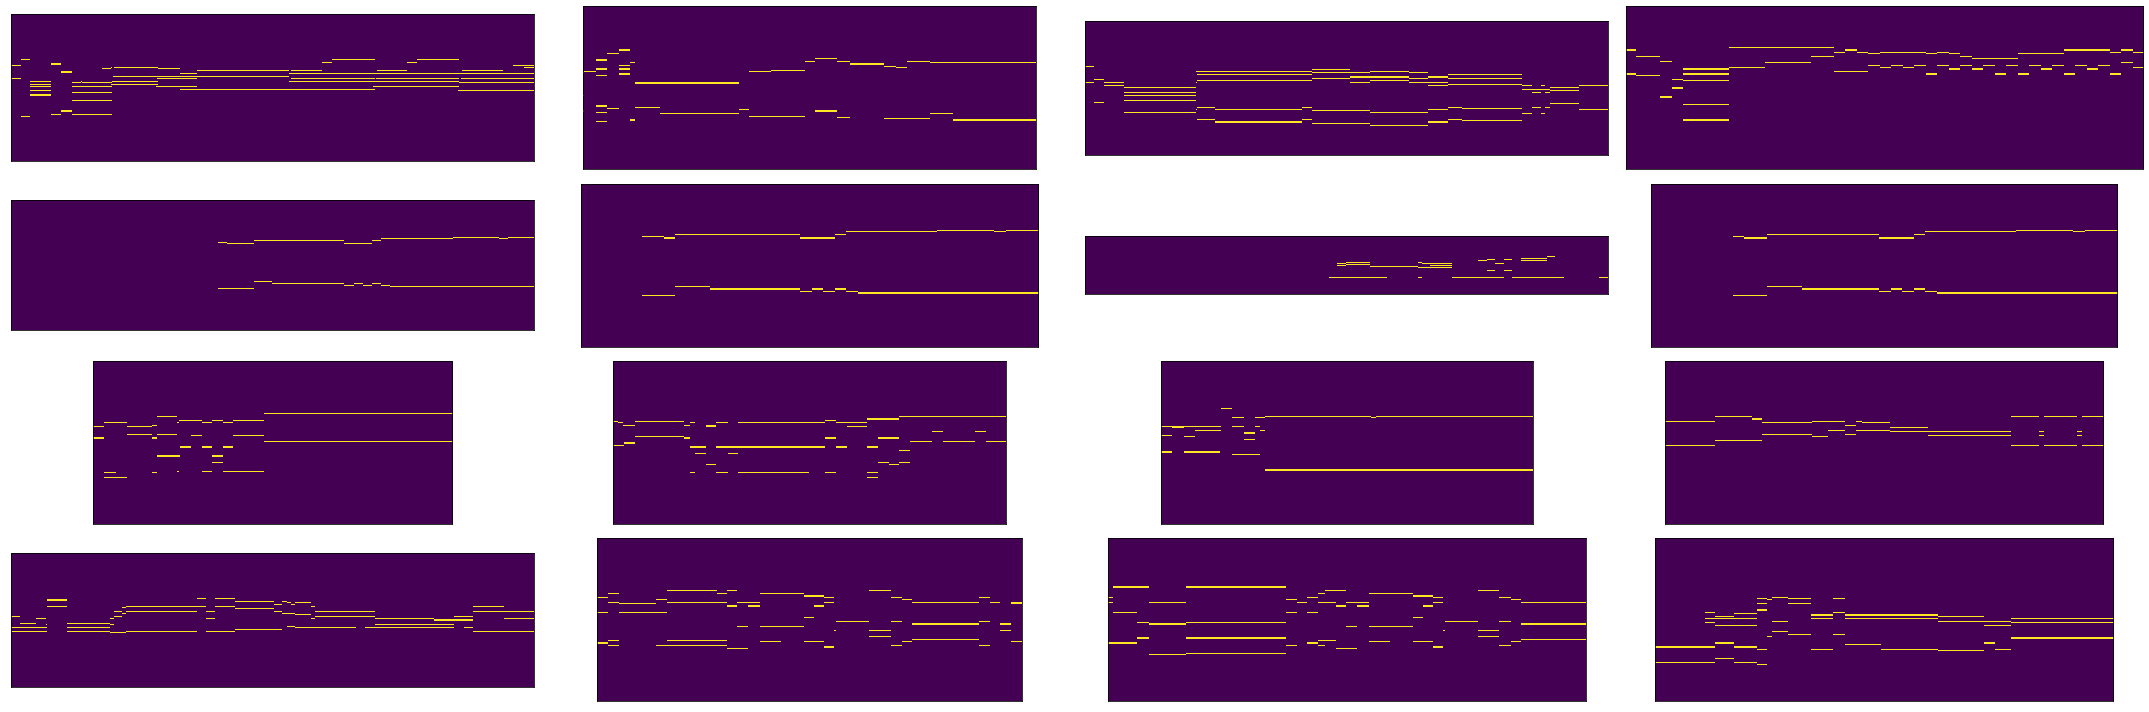

500/500 [==============================] - 13s 27ms/step - loss: 22.3752 - notes_output_loss: 5.8944 - duration_output_loss: 0.0258 - notes_output_mean_squared_error: 5.7583 - duration_output_categorical_accuracy: 0.9920 - val_loss: 1618.4253 - val_notes_output_loss: 19.9350 - val_duration_output_loss: 2.4976 - val_notes_output_mean_squared_error: 20.0215 - val_duration_output_categorical_accuracy: 0.6535
Epoch 20/25
 97/500 [====>.........................] - ETA: 2s - loss: 1782.3878 - notes_output_loss: 20.1034 - duration_output_loss: 2.7536 - notes_output_mean_squared_error: 20.1856 - duration_output_categorical_accuracy: 0.6687

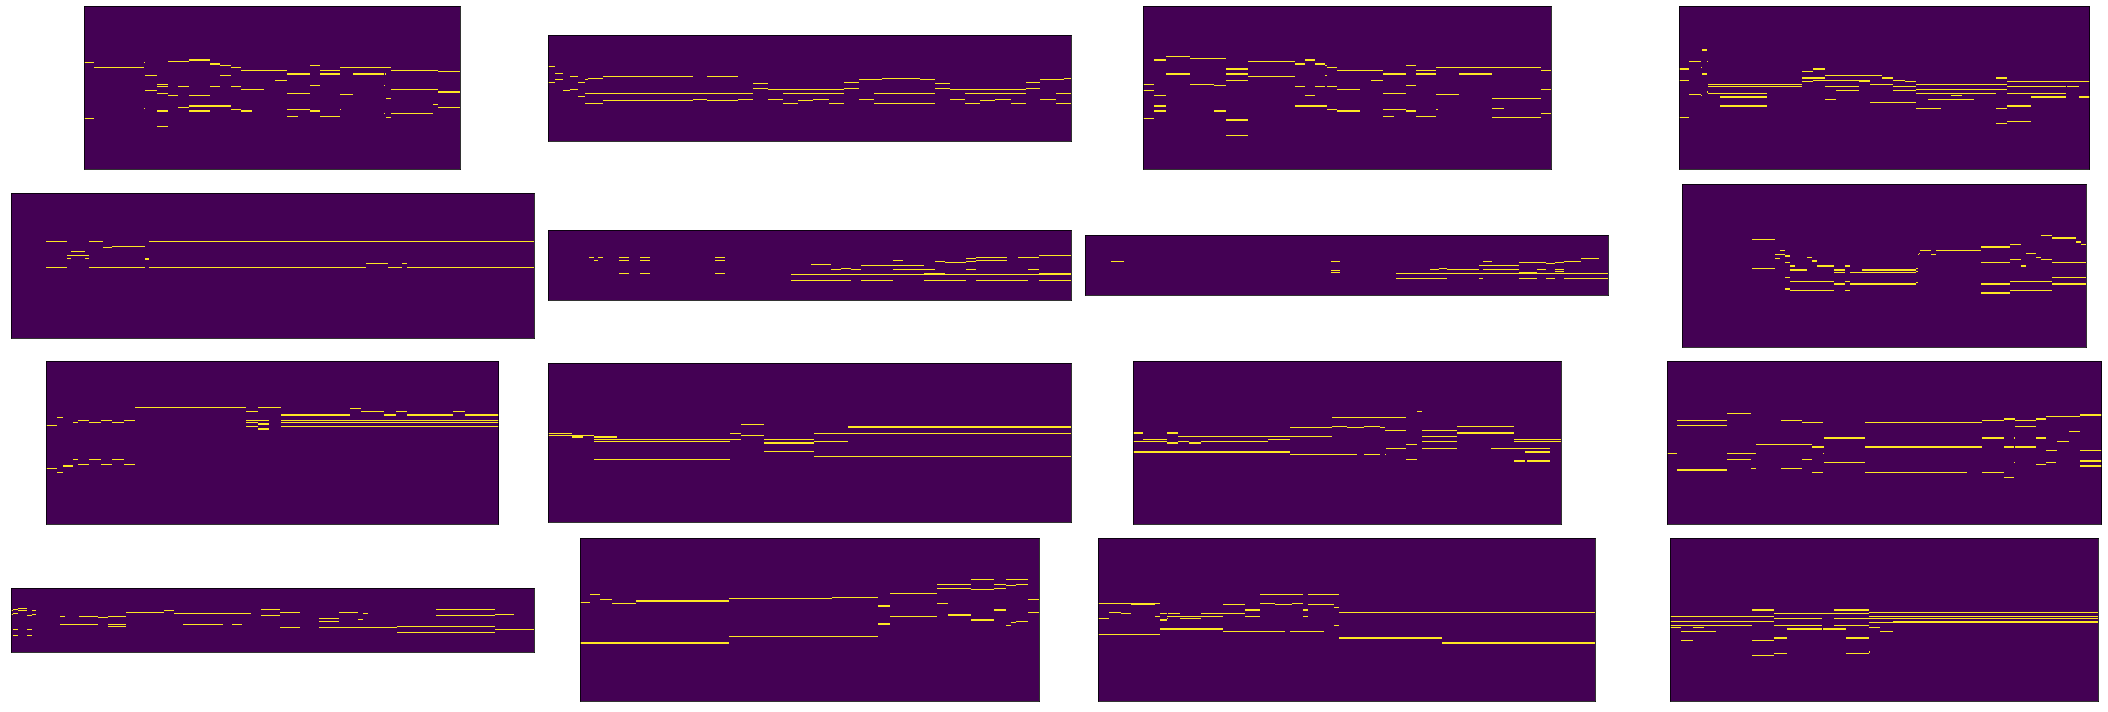

500/500 [==============================] - 13s 27ms/step - loss: 24.2575 - notes_output_loss: 5.8150 - duration_output_loss: 0.0288 - notes_output_mean_squared_error: 5.7020 - duration_output_categorical_accuracy: 0.9910 - val_loss: 1786.5159 - val_notes_output_loss: 20.0755 - val_duration_output_loss: 2.7601 - val_notes_output_mean_squared_error: 20.1726 - val_duration_output_categorical_accuracy: 0.6676
Epoch 21/25
 93/500 [====>.........................] - ETA: 2s - loss: 1582.6861 - notes_output_loss: 18.1833 - duration_output_loss: 2.4445 - notes_output_mean_squared_error: 18.1773 - duration_output_categorical_accuracy: 0.7028

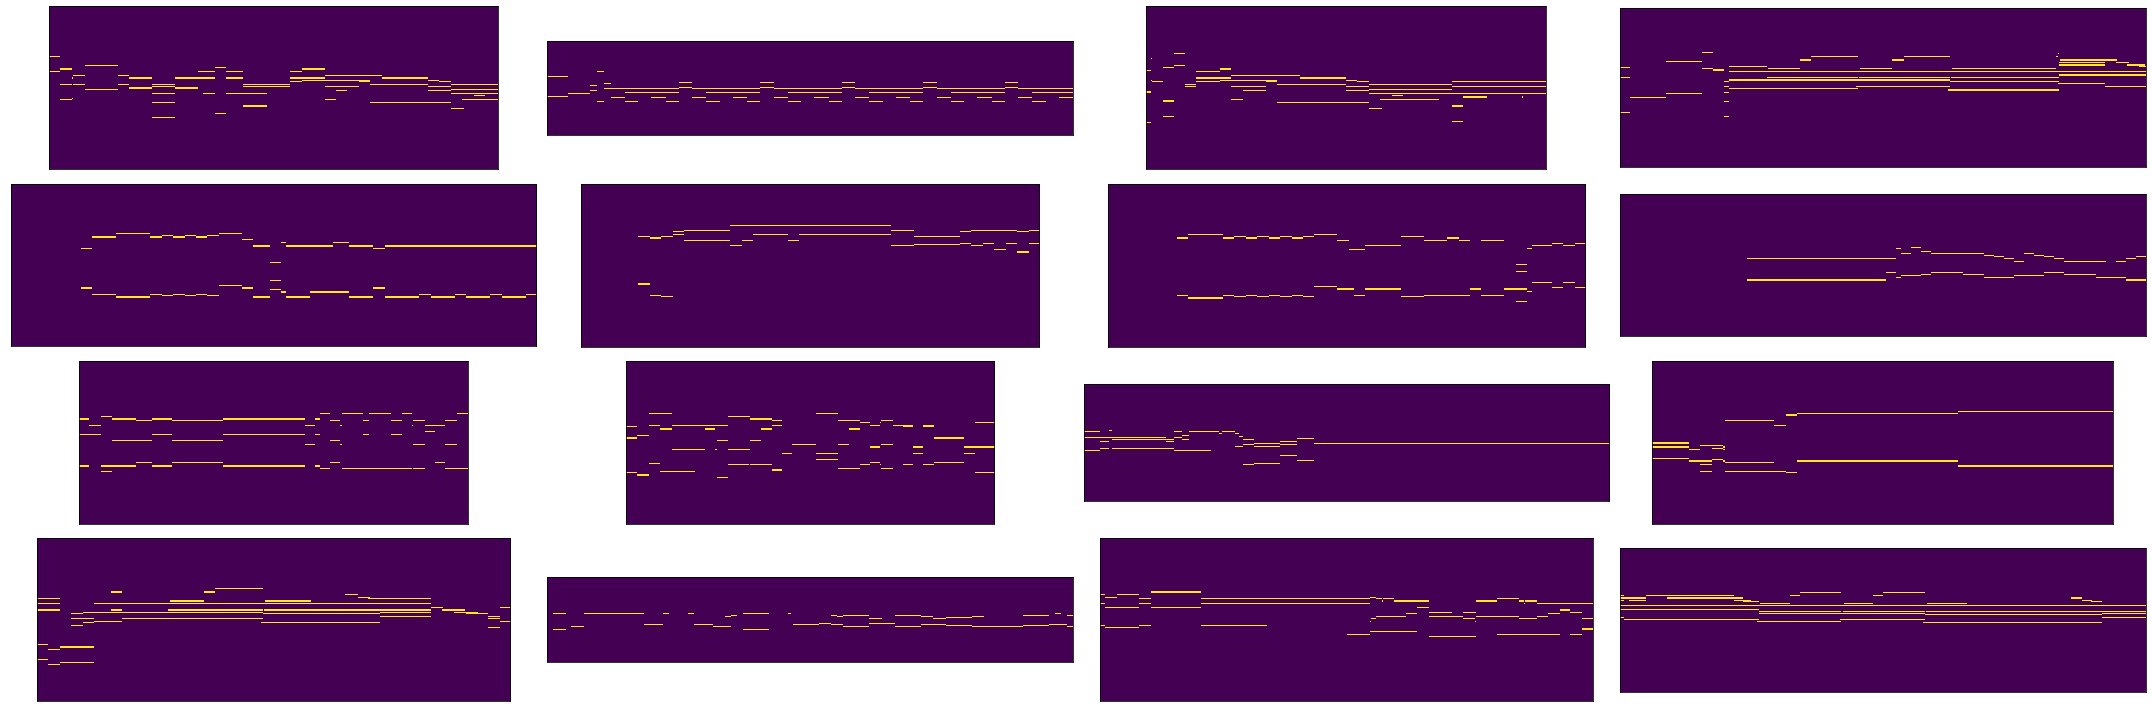

500/500 [==============================] - 14s 27ms/step - loss: 26.1954 - notes_output_loss: 5.7713 - duration_output_loss: 0.0319 - notes_output_mean_squared_error: 5.6879 - duration_output_categorical_accuracy: 0.9892 - val_loss: 1564.4076 - val_notes_output_loss: 18.1994 - val_duration_output_loss: 2.4160 - val_notes_output_mean_squared_error: 18.2207 - val_duration_output_categorical_accuracy: 0.7045
Epoch 22/25
 98/500 [====>.........................] - ETA: 2s - loss: 1871.6229 - notes_output_loss: 18.6837 - duration_output_loss: 2.8952 - notes_output_mean_squared_error: 18.7266 - duration_output_categorical_accuracy: 0.6540

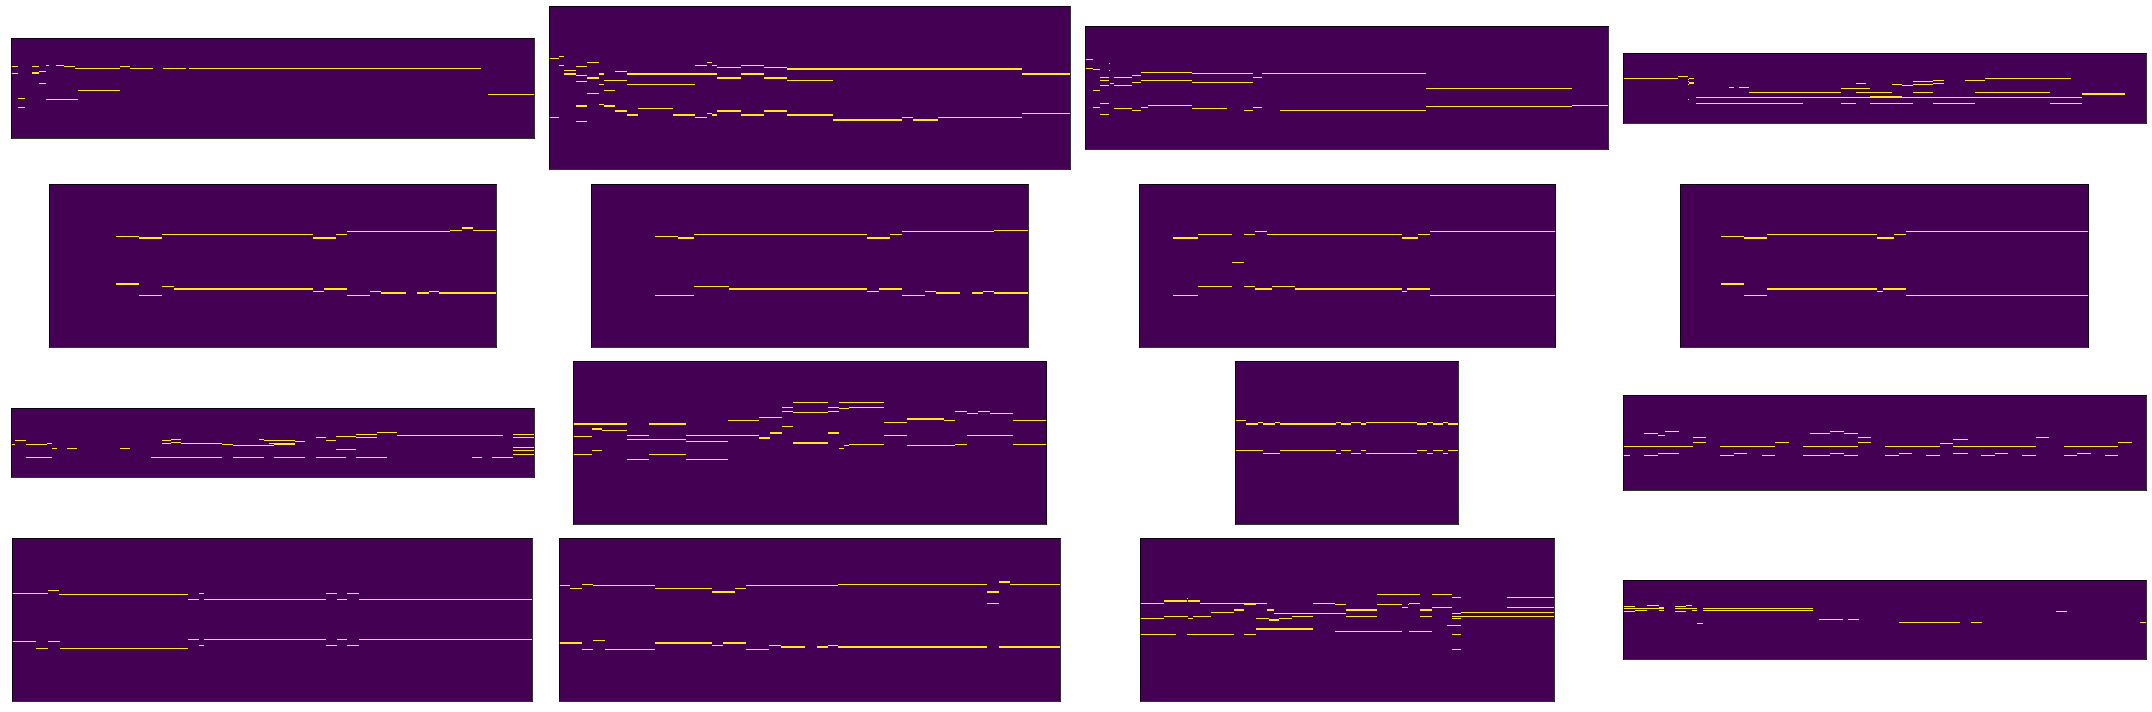

500/500 [==============================] - 13s 26ms/step - loss: 22.3510 - notes_output_loss: 5.6081 - duration_output_loss: 0.0262 - notes_output_mean_squared_error: 5.4881 - duration_output_categorical_accuracy: 0.9913 - val_loss: 1868.4171 - val_notes_output_loss: 18.7228 - val_duration_output_loss: 2.8901 - val_notes_output_mean_squared_error: 18.7526 - val_duration_output_categorical_accuracy: 0.6543
Epoch 23/25
 98/500 [====>.........................] - ETA: 2s - loss: 2073.7464 - notes_output_loss: 20.3342 - duration_output_loss: 3.2085 - notes_output_mean_squared_error: 20.6294 - duration_output_categorical_accuracy: 0.6388

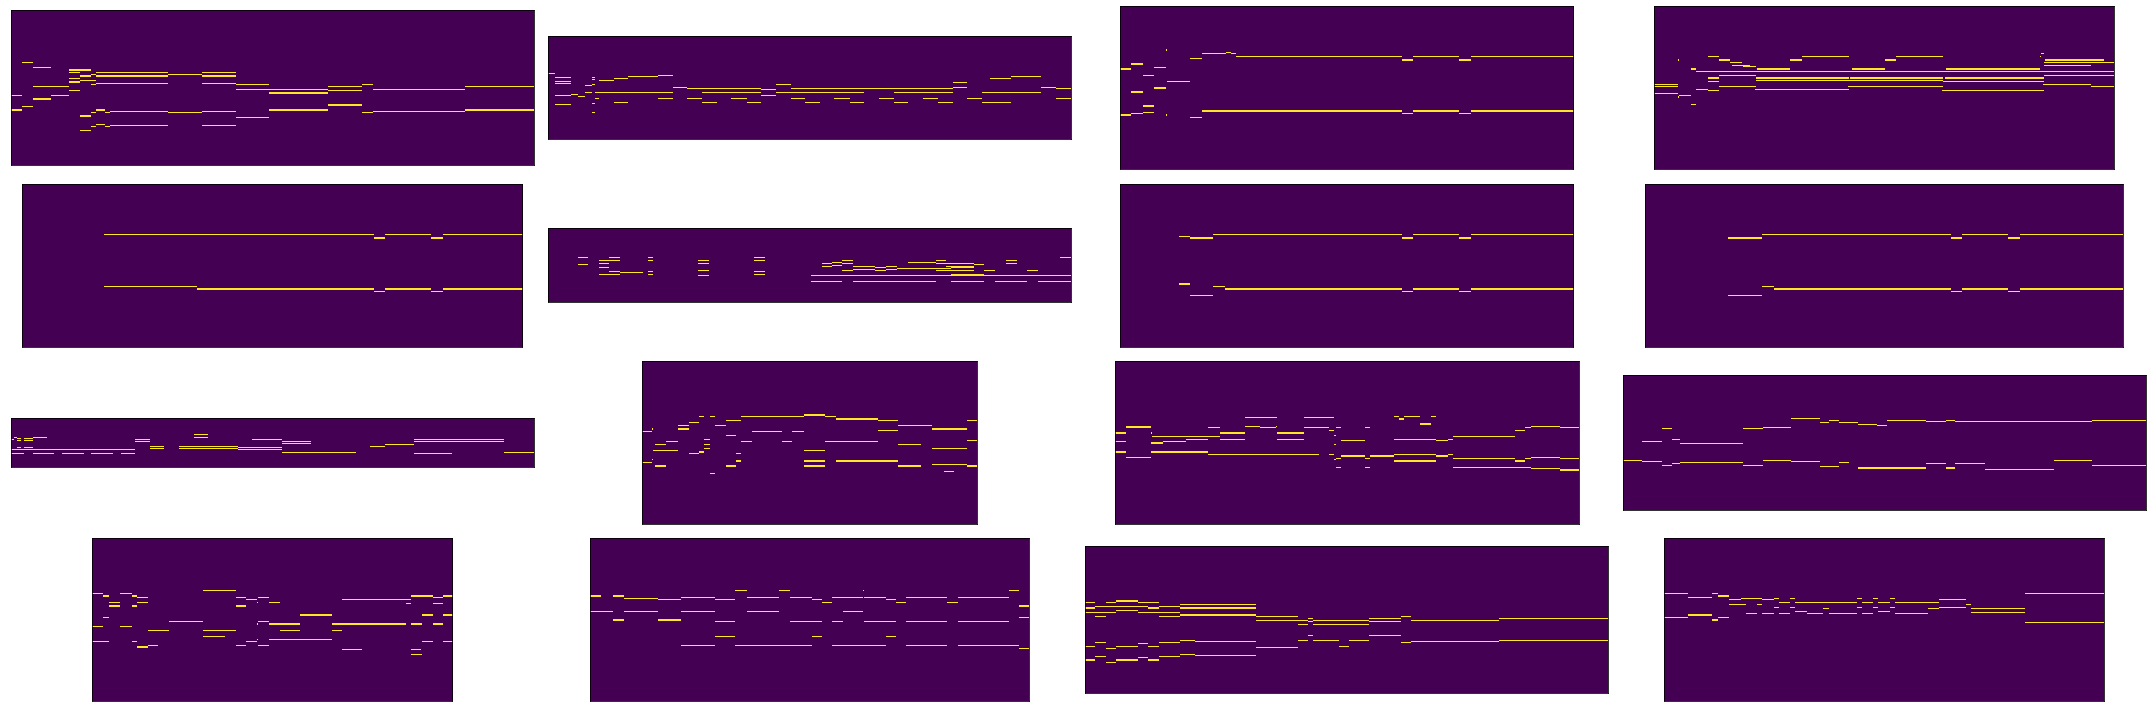

500/500 [==============================] - 14s 28ms/step - loss: 21.1327 - notes_output_loss: 5.3041 - duration_output_loss: 0.0247 - notes_output_mean_squared_error: 5.2153 - duration_output_categorical_accuracy: 0.9916 - val_loss: 2075.5771 - val_notes_output_loss: 20.3591 - val_duration_output_loss: 3.2113 - val_notes_output_mean_squared_error: 20.6568 - val_duration_output_categorical_accuracy: 0.6385
Epoch 24/25
 93/500 [====>.........................] - ETA: 2s - loss: 1665.9192 - notes_output_loss: 19.0985 - duration_output_loss: 2.5732 - notes_output_mean_squared_error: 19.0454 - duration_output_categorical_accuracy: 0.6755

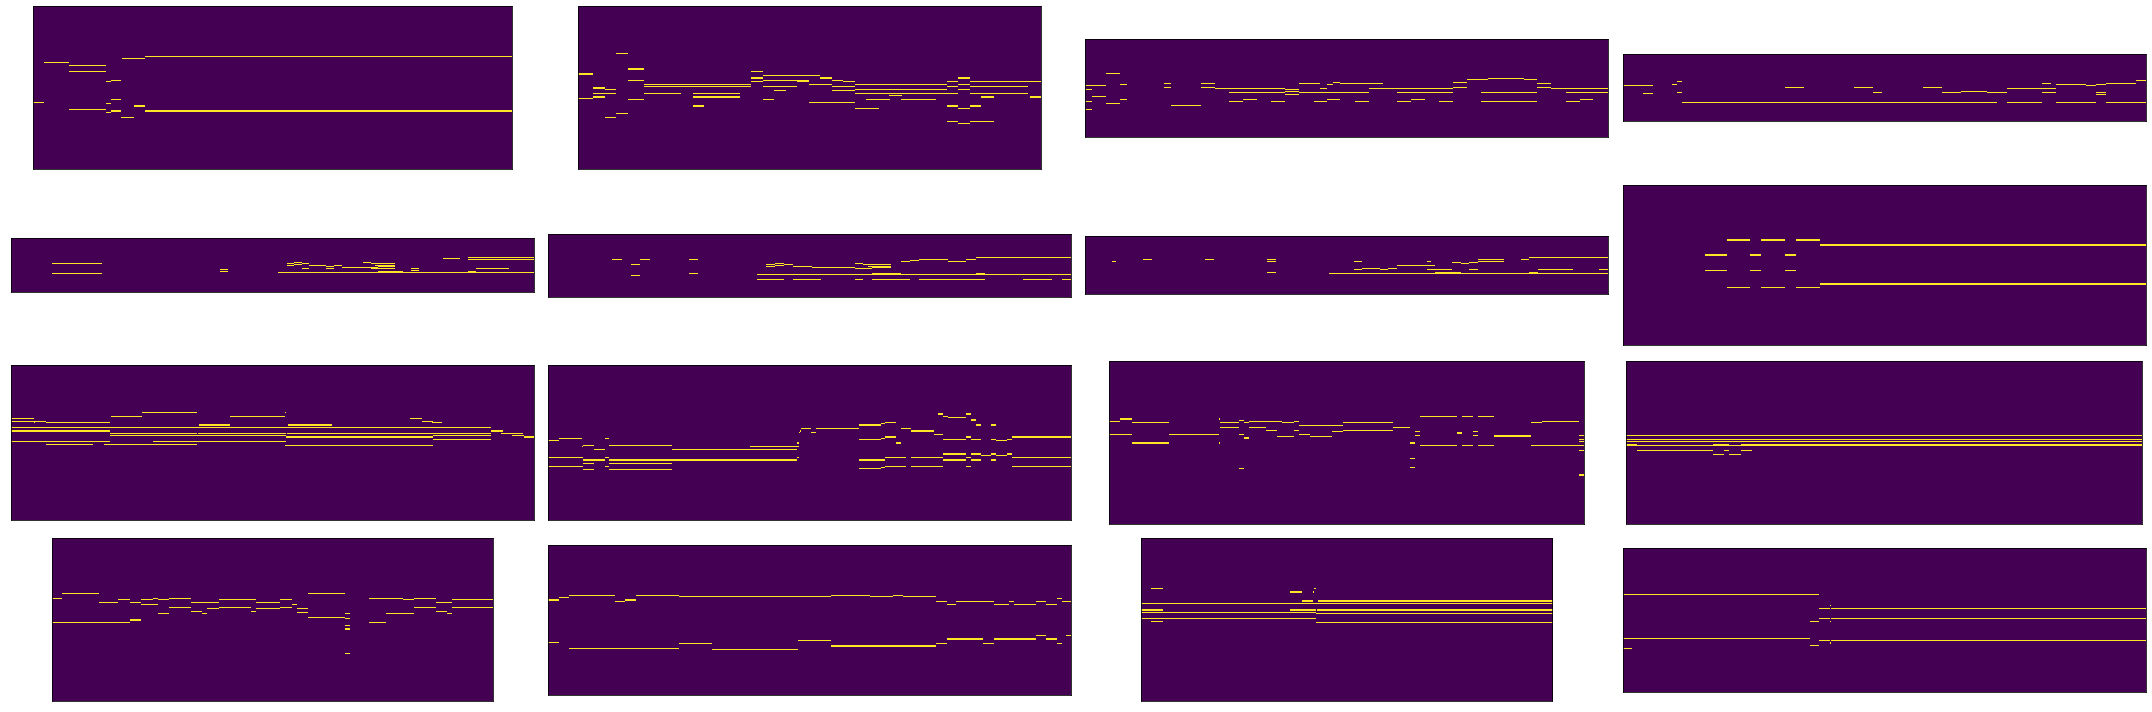

500/500 [==============================] - 15s 29ms/step - loss: 25.2928 - notes_output_loss: 5.2938 - duration_output_loss: 0.0312 - notes_output_mean_squared_error: 5.2129 - duration_output_categorical_accuracy: 0.9905 - val_loss: 1657.6918 - val_notes_output_loss: 18.9631 - val_duration_output_loss: 2.5605 - val_notes_output_mean_squared_error: 18.9170 - val_duration_output_categorical_accuracy: 0.6785
Epoch 25/25
 99/500 [====>.........................] - ETA: 2s - loss: 1567.8976 - notes_output_loss: 18.9732 - duration_output_loss: 2.4202 - notes_output_mean_squared_error: 18.8190 - duration_output_categorical_accuracy: 0.7007

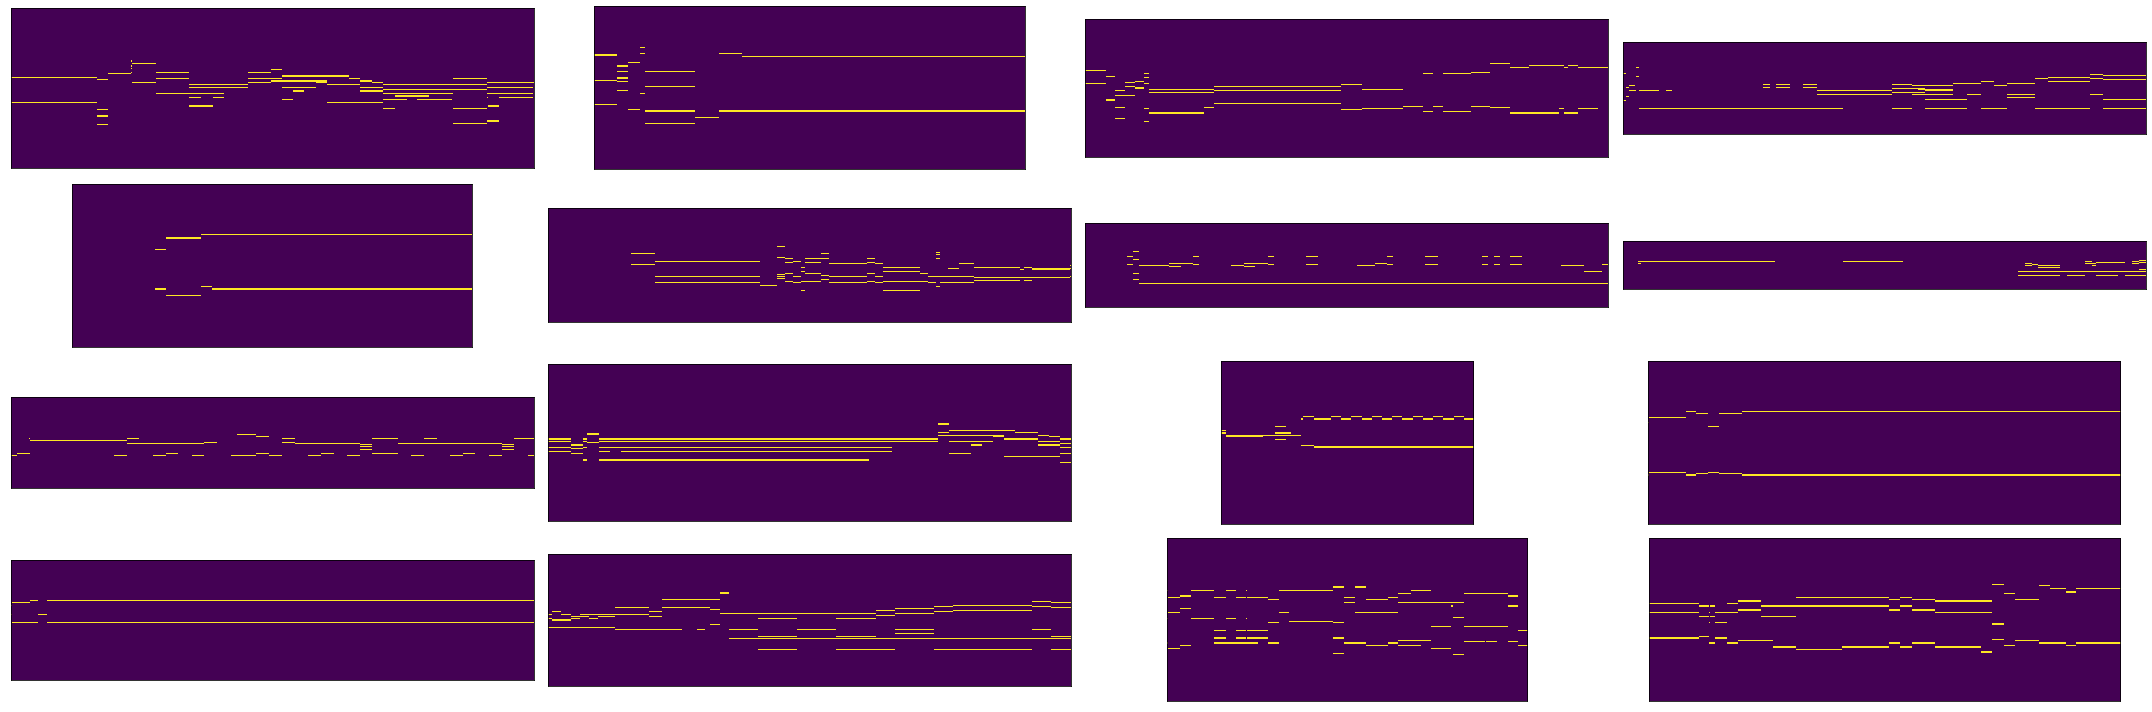

500/500 [==============================] - 14s 27ms/step - loss: 20.8144 - notes_output_loss: 5.1846 - duration_output_loss: 0.0244 - notes_output_mean_squared_error: 5.0841 - duration_output_categorical_accuracy: 0.9917 - val_loss: 1564.9777 - val_notes_output_loss: 18.9789 - val_duration_output_loss: 2.4156 - val_notes_output_mean_squared_error: 18.8281 - val_duration_output_categorical_accuracy: 0.7005


In [25]:
if save_logs_and_models:
    import shutil
    shutil.rmtree(tb_logs_dir)

EPOCHS = 25
STEPS_PER_EPOCH = 500
TEST_STEPS = 100

start_time = time()
model.fit_generator(
    data_gen,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=test_gen,
    validation_steps=TEST_STEPS,
    callbacks=[log_callback, gen_callback, mc_best, mc_last, tb] if save_logs_and_models else [gen_callback] #mc, es]
)

minutes_elapsed += (time() - start_time) // 60
epochs_elapsed += EPOCHS

### convert gpu model to cpu

In [ ]:
model_path = 'lstm_clustered_time_embedded/model_best.h5'
model = K.models.load_model(os.path.join(models_base_path, model_path))

In [ ]:
from src.training.common.CUDNNLSTM_LSTM import cudnnlstm_to_lstm

cpu_model = cudnnlstm_to_lstm(model)
cpu_model.compile(
    loss='mean_squared_error',
    optimizer='adam', 
    metrics=["mean_squared_error"],
)

K.models.save_model(cpu_model, os.path.join(models_base_path, model_path).replace('.h5', '_cpu.h5'))